### Essential libaries - From Topic Modelling scrapping and pre-processing

In [2]:
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import json

In [3]:
#https://www.binarystudy.com/2022/12/how-to-install-specific-version-of-Numpy-with-PIP.html#:~:text=To%20install%20a%20specific%20version%20of%20NumPy%20using%20PIP%2C%20use,uninstall%20and%20then%20install%20it.
np. __version__
#pip install --force-reinstall numpy==1.23.5

'1.23.5'

### 2.1 Topic modelling explorations

In [4]:
#packages to install
#!pip install sentence-transformers
#!pip install umap-learn
#!conda install -c conda-forge hdbscan
#!pip install bertopic[spacy]

In [165]:
import torch
!python --version

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the number of CUDA devices and their names
if cuda_available:
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA devices available.")

Python 3.11.5
CUDA available: True
Number of CUDA devices: 1
CUDA Device 0: NVIDIA RTX A1000 Laptop GPU


### 2.1 Helper functions

In [6]:
from collections import defaultdict

def merge_similar_keys(data): #Group the speeches by speakers
    merged_dict = defaultdict(list)
    for key, value in data.items():
        normalized_key = key.split(' (')[0]
        merged_dict[normalized_key].extend(value)
    return dict(merged_dict)

def save_json_file(file_name, obj):  #"speech", "speaker" #text_lst ,strong_text_lst
    json_data = json.dumps(obj) #text_lst #strong_text_lst
    # Write to a file
    with open(f'{file_name}.json', 'w') as json_file:
        json_file.write(json_data)
        
def load_json_file(json_file_name):#"speaker" "speech"
    with open(f'{json_file_name}.json', 'r') as file:
        data = json.load(file)
    return data

### 2.1.1 BERT Topic

In [54]:
#!pip install bertopic need this conda install -c conda-forge hdbscan https://github.com/MaartenGr/BERTopic/issues/816
#!pip install datasets
#!pip install openai
#!pip install nltk
# !python -m spacy download en_core_web_sm  For part of Speech https://bobbyhadz.com/blog/os-error-cant-find-model-en-core-web-sm

#!pip install gensim

In [7]:
#from datasets import load_dataset
#dataset = load_dataset("CShorten/ML-ArXiv-Papers")["train"]

# Extract abstracts to train on and corresponding titles
#abstracts = dataset["abstract"]
#titles = dataset["title"]

#HANSARD datasets
President_address_with_ministers_14Parliament = load_json_file("President_address_with_ministers_14Parliament")
President_address_debate_first_allocated_day_14Parliament = load_json_file("Presidential's_address_debate_first_allocated_day_14Parliament")
President_address_debate_second_allocated_day_14Parliament = load_json_file("Presidential's_address_debate_second_allocated_day_14Parliament")
President_address_debate_third_allocated_day_14Parliament = load_json_file("Presidential's_address_debate_third_allocated_day_14Parliament")
President_address_debate_forth_allocated_day_14Parliament = load_json_file("Presidential's_address_debate_fourth_allocated_day_14Parliament")
President_address_debate_fifth_allocated_day_14Parliament = load_json_file("Presidential's_address_debate_fifth_allocated_day_14Parliament")

### 2.1.1a)  Topic Modelling by whole document

In [8]:
#Presidential Address
PA_MIN_combined_docs = [item for sublist in President_address_with_ministers_14Parliament.values() for item in sublist]
PA_debate_firstDay_combined_docs = [item for sublist in President_address_debate_first_allocated_day_14Parliament.values() for item in sublist]
PA_debate_secondDay_combined_docs = [item for sublist in President_address_debate_second_allocated_day_14Parliament.values() for item in sublist]
PA_debate_thirdDay_combined_docs = [item for sublist in President_address_debate_third_allocated_day_14Parliament.values() for item in sublist]
PA_debate_fourthDay_combined_docs = [item for sublist in President_address_debate_forth_allocated_day_14Parliament.values() for item in sublist]
PA_debate_fifthDay_combined_docs = [item for sublist in President_address_debate_fifth_allocated_day_14Parliament.values() for item in sublist]
PA_combined_lst_docs = PA_debate_firstDay_combined_docs + PA_debate_secondDay_combined_docs+  PA_debate_secondDay_combined_docs + PA_debate_thirdDay_combined_docs + PA_debate_fifthDay_combined_docs

print(len(PA_combined_lst_docs)) #Total number of speeches
print(type(PA_combined_lst_docs))
print(sum([len(ele) for ele in PA_combined_lst_docs])) #Total characters in Presidential's Address
PA_combined_lst_docs

105
<class 'list'>
831198


['Mr Speaker, Sir, I beg to move, "that the following Address in reply to the Speech of the President be agreed to: \'We, the Parliament of the Republic of Singapore, express our thanks to the President for the Speech which she delivered on behalf of the Government at the Opening of the Second Session of this Parliament\'."Sir, a week ago in this House, her Excellency Mdm Halimah Yacob, the President of the Republic of Singapore, delivered a speech on the priorities, policies and programmes of the Government for the remainder of the current term of office.  A plain review of the President’s speech and the 21 addenda issued by the respective Ministries and Prime Minister’s Office (PMO) since, reveals much more than that.The plans go well beyond the remainder of the current term of this Government’s office. A good number of these plans, especially the ones dealing with the transformation of our defence capabilities, implementing our net zero ambition, developing our sustainable aviation 

In [9]:
#Combined COS
cos_head_list = [
    "COS_HEAD_P_MHA",
    "COS_HEAD_F_Parliment",
    "COS_HEAD_O_MOH",
    "COS_HEAD_I_MSF",
    "COS_HEAD_W_MOT_I",
    "COS_HEAD_W_MOT_II",
    "COS_HEAD_I_MSF_II",
    "COS_HEAD_T_MND",
    "COS_HEAD_L_MSE_II",
    "COS_HEAD_L_MSE_I",
    "COS_HEAD_S_MOM",
    "COS_HEAD_K_MOE_II",
    "COS_HEAD_K_MOE_I",
    "COS_HEAD_V_MTI",
    "COS_HEAD_Q_MCI",
    "COS_HEAD_N_MFA",
    "COS_HEAD_J_MOD_I",
    "COS_HEAD_J_MOD_II",
    "COS_HEAD_U_PMO"
]

cos_speech_allMinsitries = []
for cos in cos_head_list:
    print(f"--------- Current COS: {cos}------------")
    cos_json = load_json_file(cos)
    cos_all_speakerSpeechDict = merge_similar_keys(cos_json)
    print(f"Total number of speakers: {len(cos_all_speakerSpeechDict.keys())}")
    print("\n")
    #for speaker, text_lst in cos_merged.items():
    #    print(speaker, len(text_lst))
    #    print("\n")
    #    for speech in text_lst:
    #        print(speech[:500])
    #        print("\n")
    cos_speech_only =  [item for sublist in cos_all_speakerSpeechDict.values() for item in sublist]
    cos_speech_allMinsitries.append(cos_speech_only)

#cos_speech_allMinsitries
print("Number of COS speeches:")
print(len(cos_speech_allMinsitries))
print("Total number of speech for first COS scrapped:")
print(len(cos_speech_allMinsitries[0]))
#print(cos_speech_allMinsitries[0])
    
combined_cos_speech = [item for sublist in cos_speech_allMinsitries for item in sublist]
print("----------- TOTAL SPEECHES FOR ALL COS IN ALL MINISTRIES ----------")
print(len(combined_cos_speech))
print(type(combined_cos_speech))
print(sum([len(ele) for ele in combined_cos_speech]))

--------- Current COS: COS_HEAD_P_MHA------------
Total number of speakers: 17


--------- Current COS: COS_HEAD_F_Parliment------------
Total number of speakers: 2


--------- Current COS: COS_HEAD_O_MOH------------
Total number of speakers: 26


--------- Current COS: COS_HEAD_I_MSF------------
Total number of speakers: 21


--------- Current COS: COS_HEAD_W_MOT_I------------
Total number of speakers: 19


--------- Current COS: COS_HEAD_W_MOT_II------------
Total number of speakers: 11


--------- Current COS: COS_HEAD_I_MSF_II------------
Total number of speakers: 8


--------- Current COS: COS_HEAD_T_MND------------
Total number of speakers: 46


--------- Current COS: COS_HEAD_L_MSE_II------------
Total number of speakers: 12


--------- Current COS: COS_HEAD_L_MSE_I------------
Total number of speakers: 14


--------- Current COS: COS_HEAD_S_MOM------------
Total number of speakers: 33


--------- Current COS: COS_HEAD_K_MOE_II------------
Total number of speakers: 15


--------

### 2.1.2 BERTopic - Performances improvements

In [10]:
#Importing libraries
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import copy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiajun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#BERTopic works by converting documents into numerical values, called embeddings. 
#This process can be very costly, especially if we want to iterate over parameters. 
#Instead, we can calculate those embeddings once and feed them to BERTopic to skip calculating embeddings each time.

#Diff embeddings model train on different models- diff understanding of models- Convert to vector space
#New data map into the previous vector space; better than lexicon apporach
embedding_model = SentenceTransformer('all-MiniLM-L6-v2') #KIV: Just use this first -- later later can explore this
embeddings = embedding_model.encode(combined_cos_speech, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

### Optimising
- UMAP (Tried but need to FORCE to have 8 comments first; PRIORITY is making new features first)
- HDBSCAN (NOT DONE)
- ? 

#### NOTE: UMAP ABRITARY setting n_components as 8 first

In [12]:
#UMAP - Uniform Manifold Approximation and Projection; https://github.com/lmcinnes/umap
#dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction
# 1.The data is uniformly distributed on a Riemannian manifold;
# 2. The Riemannian metric is locally constant (or can be approximated as such);
# 3.The manifold is locally connected.
#-> searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure
#-> Prevents curse of dimensionality
# Stochastic(randomness) behavior; Need to set a random state of the model before passing it to BERTopic

umap_model = UMAP(n_neighbors=15, n_components=7, min_dist=0.0, metric='cosine', random_state=42)
#Rachel: PCA dim-reduction: Usually 1st to 2nd PC ok alr
#Common number of components- 7th D - capture more; 
#1st component - 45%, 2nd component - 35%, if up to 7th, 99%
#Considerations: How much data you can capture if you increase components? Trade off is compute(time to run)

#If want to explore; If 1st component(how much capture?)
#NOTE: Check how people optimise

In [13]:
####HDBSCAN -  Hierarchical Density-Based Spatial Clustering of Applications with Noise
#Advised to control the number of topics through the cluster model which is by default HDBSCAN. 
#HDBSCAN has a parameter, namely `min_topic_size` that indirectly controls the number of topics that will be created.
#min_cluster_size = The minimum number of samples in a group for that group to be considered a cluster; 
#groupings smaller than this size will be left as noise.
#min_samples = The number of samples in a neighborhood for a point to be considered as a core point. 
#This includes the point itself. When None, defaults to min_cluster_size.

#QNS: How to determine appropirate number of cluster size? #Using 20 first as a test - need to vary
#Rachel: Keep this constant first
hdbscan_model = HDBSCAN(min_cluster_size=40, min_samples=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [14]:
#CountVectorizer Improved default representation
#Remove stopwords
#Ignore infrequent words
#Adding common words that appear in previous topics
#Increasing n-gram range -> Consider topic representation made up of one or two words

#Add in the ones you found in topic modelling - This one do as user
all_stopwords = list(stopwords.words('english')) + ["mr" , "singapore" , "sg", "minister", "chairman", "government", "also", "would", "like", "need",  
 "stand part", "head ordered", "ordered", "ordered stand","amendment","estimates","leave", "sum", "stand", "leave", "thank", "withdraw", "part", "singaporeans","senior ministers", "ministers" , "senior parliamentary", "parliamentary" , "parliamentary secretary"]
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=all_stopwords)

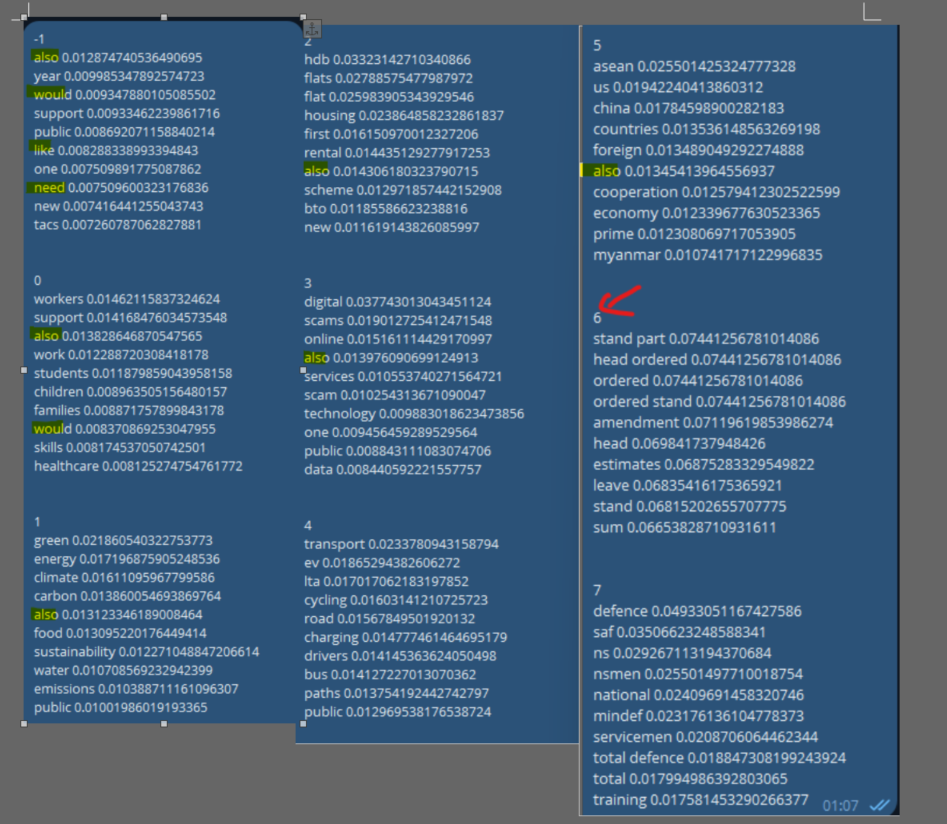

### 2.1.3 BERTopic - Additional Representations

In [15]:
#READ UP THESE 3, understand and explain their relevance next catchup - DONE as of 16th Nov

# KeyBERTInspired
  ##A method that derives inspiration from how KeyBERT works: Increase coherence and reduces stopwords from appearing in topic representatations
  #https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#multimodal-data
  
  #Note: KeyBERT to generate a number of keywords for each document and then build a vocabulary on top of that as the input for BERTopic. 
  #This way, we can select words that we know have meaning to a topic, without focusing on the centroid of that cluster. 
  #This also allows more frequent words to pop-up regardless of the structure and density of a cluster
  
# PartOfSpeech- Tag which words noun, verb,
  # Using SpaCy's POS tagging to extract words

#MaximalMarginalRelevance
  #Diversify the topic words
    
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
import en_core_web_sm
#pos_model = en_core_web_sm.load()
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3) #KIV, allow user to change

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

### Note to self: I disabled umap_model and hdbscan_model cause they forcing the number of topics

In [39]:
len(combined_cos_speech)

763

In [98]:
enhanced_BERT = BERTopic(
    #umap_model=umap_model,
    #hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    min_topic_size = 10, #Min number of topcis
    nr_topics = 15, #Number of topics to reduce
    top_n_words=15, #User judgement call; can put 20 or 25 - KIV: Dont optimize first
    language='english',
    calculate_probabilities=True,
    verbose=True
)

#Alternatively: Can use BERTopic itself to choose no of topics or clusters - CURRENTLY DOING THAT IN THIS FEATURE
cos_topics, cos_probs = enhanced_BERT.fit_transform(combined_cos_speech)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-11-30 07:41:13,203 - BERTopic - Transformed documents to Embeddings
2023-11-30 07:41:14,784 - BERTopic - Reduced dimensionality
2023-11-30 07:41:14,816 - BERTopic - Clustered reduced embeddings
2023-11-30 07:41:33,887 - BERTopic - Reduced number of topics from 21 to 15


### Deep copying BERTopic object to allow for augmentations

In [106]:
enhanced_BERT_copy = copy.deepcopy(enhanced_BERT)

In [107]:
enhanced_BERT_copy.get_topic_info()

Topic  Count                                         Name  \
0      -1    173                 -1_support_workers_work_year   
1       0    127                      0_green_asean_energy_us   
2       1     60                  1_digital_scams_scam_online   
3       2     53                   2_transport_ev_lta_cycling   
4       3     52           3_families_support_social_children   
5       4     51                     4_flats_flat_housing_hdb   
6       5     46            5_healthcare_health_care_patients   
7       6     39          6_training_skills_workers_companies   
8       7     39                7_students_school_schools_moe   
9       8     31  8_head_head main_head development_withdrawn   
10      9     30                       9_defence_saf_ns_nsmen   
11     10     22               10_workers_cpf_retirement_jobs   
12     11     16                   11_shops_hawker_coffee_hdb   
13     12     13          12_cpib_corruption_answer_questions   
14     13     11             13_preschool_early_children_ecda   

                                       Representation  \
0   [support, workers, work, year, new, students, ...   
1   [green, asean, energy, us, climate, carbon, fo...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, ev, lta, cycling, road, charging, ...   
4   [families, support, social, children, pwds, wo...   
5   [flats, flat, housing, hdb, first, rental, bto...   
6   [healthcare, health, care, patients, moh, medi...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, moe, education, le...   
9   [head, head main, head development, withdrawn,...   
10  [defence, saf, ns, nsmen, mindef, national, se...   
11  [workers, cpf, retirement, jobs, work, employm...   
12  [shops, hawker, coffee, hdb, hawker centres, c...   
13  [cpib, corruption, answer, questions, kom, sai...   
14  [preschool, early, children, ecda, childcare, ...   

                                              KeyBERT  \
0   [covid 19, growth, economy, sustainability, pa...   
1   [asean, sustainability, climate change, plans,...   
2   [digital infrastructure, digital services, dig...   
3   [public transport, buses, mobility, bus, roads...   
4   [support families, income families, persons di...   
5   [housing options, households, housing, hdb fla...   
6   [healthcare providers, healthcare, healthcare ...   
7   [skillsfuture, training providers, training, s...   
8   [curriculum, education, students, educational,...   
9   [ministry, withdrawn, beg withdrawn, cut withd...   
10  [national servicemen, defence, national servic...   
11  [retirement adequacy, senior workers, older wo...   
12  [hawker centres, hawkers, hawker food, afforda...   
13  [corruption, anti corruption, bribery acts, pr...   
14  [preschool centres, childcare infant, preschoo...   

                                                  MMR  \
0   [support, workers, work, year, students, platf...   
1   [green, asean, energy, climate, carbon, sustai...   
2   [digital, scams, scam, online, services, data,...   
3   [ev, lta, cycling, road, charging, bus, public...   
4   [families, support, pwds, caregivers, msf, emp...   
5   [flats, housing, hdb, rental, bto, home, resal...   
6   [healthcare, health, patients, moh, healthier,...   
7   [training, skills, companies, industry, traini...   
8   [students, schools, moe, education, secondary,...   
9   [head, head main, head development, withdrawn,...   
10  [defence, saf, ns, mindef, servicemen, total d...   
11  [cpf, retirement, employment, senior, workforc...   
12  [shops, hawker, coffee, hdb, hawker centres, c...   
13  [cpib, corruption, questions, kom, investigati...   
14  [preschool, children, ecda, childcare, infant ...   

                                                  POS  \
0   [support, workers, work, year, new, students, ...   
1   [green, energy, climate, carbon, food, sustain...   
2   [digital, scams, scam, online, services, data,...

In [109]:
keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in enhanced_BERT_copy.topic_aspects_["KeyBERT"].items()}
enhanced_BERT_copy.set_topic_labels(keybert_topic_labels)

In [110]:
enhanced_BERT_copy.get_topic_info()

Topic  Count                                         Name  \
0      -1    173                 -1_support_workers_work_year   
1       0    127                      0_green_asean_energy_us   
2       1     60                  1_digital_scams_scam_online   
3       2     53                   2_transport_ev_lta_cycling   
4       3     52           3_families_support_social_children   
5       4     51                     4_flats_flat_housing_hdb   
6       5     46            5_healthcare_health_care_patients   
7       6     39          6_training_skills_workers_companies   
8       7     39                7_students_school_schools_moe   
9       8     31  8_head_head main_head development_withdrawn   
10      9     30                       9_defence_saf_ns_nsmen   
11     10     22               10_workers_cpf_retirement_jobs   
12     11     16                   11_shops_hawker_coffee_hdb   
13     12     13          12_cpib_corruption_answer_questions   
14     13     11             13_preschool_early_children_ecda   

                                           CustomName  \
0                         covid 19 | growth | economy   
1             asean | sustainability | climate change   
2   digital infrastructure | digital services | di...   
3                 public transport | buses | mobility   
4   support families | income families | persons d...   
5              housing options | households | housing   
6   healthcare providers | healthcare | healthcare...   
7        skillsfuture | training providers | training   
8                   curriculum | education | students   
9                ministry | withdrawn | beg withdrawn   
10   national servicemen | defence | national service   
11  retirement adequacy | senior workers | older w...   
12             hawker centres | hawkers | hawker food   
13        corruption | anti corruption | bribery acts   
14  preschool centres | childcare infant | prescho...   

                                       Representation  \
0   [support, workers, work, year, new, students, ...   
1   [green, asean, energy, us, climate, carbon, fo...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, ev, lta, cycling, road, charging, ...   
4   [families, support, social, children, pwds, wo...   
5   [flats, flat, housing, hdb, first, rental, bto...   
6   [healthcare, health, care, patients, moh, medi...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, moe, education, le...   
9   [head, head main, head development, withdrawn,...   
10  [defence, saf, ns, nsmen, mindef, national, se...   
11  [workers, cpf, retirement, jobs, work, employm...   
12  [shops, hawker, coffee, hdb, hawker centres, c...   
13  [cpib, corruption, answer, questions, kom, sai...   
14  [preschool, early, children, ecda, childcare, ...   

                                              KeyBERT  \
0   [covid 19, growth, economy, sustainability, pa...   
1   [asean, sustainability, climate change, plans,...   
2   [digital infrastructure, digital services, dig...   
3   [public transport, buses, mobility, bus, roads...   
4   [support families, income families, persons di...   
5   [housing options, households, housing, hdb fla...   
6   [healthcare providers, healthcare, healthcare ...   
7   [skillsfuture, training providers, training, s...   
8   [curriculum, education, students, educational,...   
9   [ministry, withdrawn, beg withdrawn, cut withd...   
10  [national servicemen, defence, national servic...   
11  [retirement adequacy, senior workers, older wo...   
12  [hawker centres, hawkers, hawker food, afforda...   
13  [corruption, anti corruption, bribery acts, pr...   
14  [preschool centres, childcare infant, preschoo...   

                                                  MMR  \
0   [support, workers, work, year, students, platf...   
1   [green, asean, energy, climate, carbon, sustai...   
2   [digital, scams, scam, online, services, data,...

### After seeing this, I have decided to merge Topic 7(5?) with outlier as removing stop words does not improve the topics - minstry|withdrawn|beg|withdrawn... seems to not mean anything

In [111]:
topics_to_merge = [-1, 8] #Example - merge topic 1 and 8
enhanced_BERT_copy.merge_topics(combined_cos_speech, topics_to_merge)

In [112]:
enhanced_BERT_copy.get_topic_info()

Topic  Count                                 Name  \
0      -1    204         -1_support_workers_work_year   
1       0    127              0_green_asean_energy_us   
2       1     60          1_digital_scams_scam_online   
3       2     53           2_transport_ev_lta_cycling   
4       3     52   3_families_support_social_children   
5       4     51             4_flats_flat_housing_hdb   
6       5     46    5_healthcare_health_care_patients   
7       6     39  6_training_skills_workers_companies   
8       7     39        7_students_school_schools_moe   
9       8     30               8_defence_saf_ns_nsmen   
10      9     22        9_workers_cpf_retirement_jobs   
11     10     16           10_shops_hawker_coffee_hdb   
12     11     13  11_cpib_corruption_answer_questions   
13     12     11     12_preschool_early_children_ecda   

                                       Representation  \
0   [support, workers, work, year, new, students, ...   
1   [green, asean, energy, us, climate, carbon, fo...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, ev, lta, cycling, road, charging, ...   
4   [families, support, social, children, pwds, wo...   
5   [flats, flat, housing, hdb, first, rental, bto...   
6   [healthcare, health, care, patients, moh, medi...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, moe, education, le...   
9   [defence, saf, ns, nsmen, mindef, national, se...   
10  [workers, cpf, retirement, jobs, work, employm...   
11  [shops, hawker, coffee, hdb, hawker centres, c...   
12  [cpib, corruption, answer, questions, kom, sai...   
13  [preschool, early, children, ecda, childcare, ...   

                                              KeyBERT  \
0   [economy, sustainability, sector, growth, covi...   
1   [asean, sustainability, climate change, plans,...   
2   [digital infrastructure, digital services, dig...   
3   [public transport, buses, mobility, bus, roads...   
4   [support families, income families, persons di...   
5   [housing options, households, housing, hdb fla...   
6   [healthcare providers, healthcare, healthcare ...   
7   [skillsfuture, training providers, training, s...   
8   [curriculum, education, students, educational,...   
9   [national servicemen, defence, national servic...   
10  [retirement adequacy, senior workers, older wo...   
11  [hawker centres, hawkers, hawker food, afforda...   
12  [corruption, anti corruption, bribery acts, pr...   
13  [preschool centres, childcare infant, preschoo...   

                                                  MMR  \
0   [support, workers, work, year, students, platf...   
1   [green, asean, energy, climate, carbon, sustai...   
2   [digital, scams, scam, online, services, data,...   
3   [ev, lta, cycling, road, charging, bus, public...   
4   [families, support, social, pwds, caregivers, ...   
5   [flats, housing, hdb, rental, bto, home, resal...   
6   [healthcare, health, patients, moh, healthier,...   
7   [training, skills, companies, training provide...   
8   [students, schools, moe, education, teachers, ...   
9   [defence, saf, ns, mindef, servicemen, total d...   
10  [cpf, retirement, employment, senior, workforc...   
11  [shops, hawker, coffee, hdb, hawker centres, c...   
12  [cpib, corruption, questions, kom, investigati...   
13  [preschool, children, ecda, childcare, infant ...   

                                                  POS  \
0   [support, workers, work, year, new, students, ...   
1   [green, energy, climate, carbon, food, sustain...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, cycling, road, charging, drivers, ...   
4   [families, support, social, children, work, ca...   
5   [flats, flat, housing, first, rental, scheme, ...   
6   [healthcare, health, care, patients, medical, ...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, education, learnin...   
9   [defen

In [113]:
#Relabelling using KEYBERT
keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in enhanced_BERT_copy.topic_aspects_["KeyBERT"].items()}
enhanced_BERT_copy.set_topic_labels(keybert_topic_labels)

In [114]:
enhanced_BERT_copy.get_topic_info()

Topic  Count                                 Name  \
0      -1    204         -1_support_workers_work_year   
1       0    127              0_green_asean_energy_us   
2       1     60          1_digital_scams_scam_online   
3       2     53           2_transport_ev_lta_cycling   
4       3     52   3_families_support_social_children   
5       4     51             4_flats_flat_housing_hdb   
6       5     46    5_healthcare_health_care_patients   
7       6     39  6_training_skills_workers_companies   
8       7     39        7_students_school_schools_moe   
9       8     30               8_defence_saf_ns_nsmen   
10      9     22        9_workers_cpf_retirement_jobs   
11     10     16           10_shops_hawker_coffee_hdb   
12     11     13  11_cpib_corruption_answer_questions   
13     12     11     12_preschool_early_children_ecda   

                                           CustomName  \
0                   economy | sustainability | sector   
1             asean | sustainability | climate change   
2   digital infrastructure | digital services | di...   
3                 public transport | buses | mobility   
4   support families | income families | persons d...   
5              housing options | households | housing   
6   healthcare providers | healthcare | healthcare...   
7        skillsfuture | training providers | training   
8                   curriculum | education | students   
9    national servicemen | defence | national service   
10  retirement adequacy | senior workers | older w...   
11             hawker centres | hawkers | hawker food   
12        corruption | anti corruption | bribery acts   
13  preschool centres | childcare infant | prescho...   

                                       Representation  \
0   [support, workers, work, year, new, students, ...   
1   [green, asean, energy, us, climate, carbon, fo...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, ev, lta, cycling, road, charging, ...   
4   [families, support, social, children, pwds, wo...   
5   [flats, flat, housing, hdb, first, rental, bto...   
6   [healthcare, health, care, patients, moh, medi...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, moe, education, le...   
9   [defence, saf, ns, nsmen, mindef, national, se...   
10  [workers, cpf, retirement, jobs, work, employm...   
11  [shops, hawker, coffee, hdb, hawker centres, c...   
12  [cpib, corruption, answer, questions, kom, sai...   
13  [preschool, early, children, ecda, childcare, ...   

                                              KeyBERT  \
0   [economy, sustainability, sector, growth, covi...   
1   [asean, sustainability, climate change, plans,...   
2   [digital infrastructure, digital services, dig...   
3   [public transport, buses, mobility, bus, roads...   
4   [support families, income families, persons di...   
5   [housing options, households, housing, hdb fla...   
6   [healthcare providers, healthcare, healthcare ...   
7   [skillsfuture, training providers, training, s...   
8   [curriculum, education, students, educational,...   
9   [national servicemen, defence, national servic...   
10  [retirement adequacy, senior workers, older wo...   
11  [hawker centres, hawkers, hawker food, afforda...   
12  [corruption, anti corruption, bribery acts, pr...   
13  [preschool centres, childcare infant, preschoo...   

                                                  MMR  \
0   [support, workers, work, year, students, platf...   
1   [green, asean, energy, climate, carbon, sustai...   
2   [digital, scams, scam, online, services, data,...   
3   [ev, lta, cycling, road, charging, bus, public...   
4   [families, support, social, pwds, caregivers, ...   
5   [flats, housing, hdb, rental, bto, home, resal...   
6   [healthcare, health, patients, moh, healthier,...   
7   [training, skills, companies, training provide...   
8   [students, schools, moe, education, teachers, ...   
9   [defen

In [49]:
enhanced_BERT_copy.get_document_info(combined_cos_speech).head(5)

Document  Topic  \
0  Mr Chairman, Sir, I beg leave to move, "That t...     -1   
1  Mdm Chairperson, with your indulgence, I would...     -1   
2  Chairman, new citizens are going to be even mo...     -1   
3  Thank you, Mdm Chair. Just some clarification ...     -1   
4  Yes, I am putting my question across now, Mdm ...     -1   

                           Name                    CustomName  \
0  -1_support_work_workers_year  covid 19 | growth | pandemic   
1  -1_support_work_workers_year  covid 19 | growth | pandemic   
2  -1_support_work_workers_year  covid 19 | growth | pandemic   
3  -1_support_work_workers_year  covid 19 | growth | pandemic   
4  -1_support_work_workers_year  covid 19 | growth | pandemic   

                                      Representation  \
0  [support, work, workers, year, new, students, ...   
1  [support, work, workers, year, new, students, ...   
2  [support, work, workers, year, new, students, ...   
3  [support, work, workers, year, new, students, ...   
4  [support, work, workers, year, new, students, ...   

                                             KeyBERT  \
0  [covid 19, growth, pandemic, encourage, famili...   
1  [covid 19, growth, pandemic, encourage, famili...   
2  [covid 19, growth, pandemic, encourage, famili...   
3  [covid 19, growth, pandemic, encourage, famili...   
4  [covid 19, growth, pandemic, encourage, famili...   

                                                 MMR  \
0  [support, work, workers, students, platform, p...   
1  [support, work, workers, students, platform, p...   
2  [support, work, workers, students, platform, p...   
3  [support, work, workers, students, platform, p...   
4  [support, work, workers, students, platform, p...   

                                                 POS  \
0  [support, work, workers, year, new, students, ...   
1  [support, work, workers, year, new, students, ...   
2  [support, work, workers, year, new, students, ...   
3  [support, work, workers, year, new, students, ...   
4  [support, work, workers, year, new, students, ...   

                                 Representative_Docs  \
0  [Thank you, Mr Chairman, let me start by answe...   
1  [Thank you, Mr Chairman, let me start by answe...   
2  [Thank you, Mr Chairman, let me start by answe...   
3  [Thank you, Mr Chairman, let me start by answe...   
4  [Thank you, Mr Chairman, let me start by answe...   

                                         Top_n_words  Probability  \
0  support - work - workers - year - new - studen...     0.642155   
1  support - work - workers - year - new - studen...     1.000000   
2  support - work - workers - year - new - studen...     0.627784   
3  support - work - workers - year - new - studen...     0.655793   
4  support - work - workers - year - new - studen...     0.611431   

   Representative_document  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

In [50]:
enhanced_BERT_copy.visualize_barchart()

In [51]:
hierarchical_topics = enhanced_BERT_copy.hierarchical_topics(combined_cos_speech)
enhanced_BERT_copy.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 7/7 [00:00<00:00, 129.32it/s]


In [53]:
#enhanced_BERT_copy.visualize_term_rank()

In [54]:
enhanced_BERT_copy.visualize_heatmap()

In [55]:
enhanced_BERT_copy.visualize_topics()

### Fixed: 10 Topics - Currently merged into 8 topics with 1 outlier

### Feature 1: Guided Topic modelling Partially done

https://maartengr.github.io/BERTopic/getting_started/guided/guided.html

Definition: Collection of techniques that guides the topic modeling approach by setting several seed topics to which the model will converge to

User to set a predefined number of topic representations that are sure to be in documents
a Guided Topic Modeling approach will try to converge at least one topic to those words

How: Create embeddings for each seeded topic by joining them and passing them through the document embedder

1. FIRST
- If the document is most similar to a seeded topic, then it will get that topic's label
- If it is most similar to the average document embedding, it will get the -1 label - I think become outlier
- Pass thorugh UMAP to create semi-supervised approach to nudge current topic to seeded topics

2. SECOND
- Take all words in seed_topic_list and assign them a multiplier larger than 1
- Increase IDF values of the words across all topics thereby increasing the likelihood seeded topic word appear in topic
- Increase the chance of an irrelevant topic having unrelated words(in practice not an issue since IDF remain low regardless of mutiplier)
- IDF value remain low regardless of mutiplier

1) Find out topics outside from presidential address (Topics provided) not quantified

Topics from https://www.istana.gov.sg/Newsroom/Speeches/2023/04/10/Speech-by-President-Halimah-Yacob-at-the-Opening-of-the-Second-Session-of-the-14th-Parliament

1. A Different World
2. Securing Our Place in the World
2. Growing our Economy
3. Refreshing Our Social Compact
4. Stewarding Our Future Singapore 
5. Our Unity as a People 

Pending: Maybe need to remove ministers as stop words
- I think maybe want to merge with outliers... how to settle outlier???
- KIV Figure out if semi or full supervised first....

In [115]:
#THIS ONE THINK AGAIN- NEED to KIV
presidential_address_categorical_names = ["a different world"
                                          , "securing our place in the world"
                                          , "growing our economy"
                                          , "refreshing our social impact"
                                         , "a stewarding our future singapore"
                                         , "our unity as a people"]

In [116]:
print(enhanced_BERT_copy.custom_labels_)
#print(list(enhanced_BERT_copy.custom_labels_))

['economy | sustainability | sector', 'asean | sustainability | climate change', 'digital infrastructure | digital services | digitalisation', 'public transport | buses | mobility', 'support families | income families | persons disabilities', 'housing options | households | housing', 'healthcare providers | healthcare | healthcare system', 'skillsfuture | training providers | training', 'curriculum | education | students', 'national servicemen | defence | national service', 'retirement adequacy | senior workers | older workers', 'hawker centres | hawkers | hawker food', 'corruption | anti corruption | bribery acts', 'preschool centres | childcare infant | preschool educators']


In [117]:
predetermined_presidential_address_seed_topic = [['different world'], #"a different world"
                            ["securing our place in the world"], #"securing our place in the world"
                            ["growing","economy"], #"growing our economy"
                            ["social", "impact"], #"refreshing our social impact
                            ["stewarding", "future"], #"a stewarding our future singapore"
                            ["unity"],
                            ["flat", "hdb","housing"]] #"our unity as a people"

In [118]:
enhanced_BERT_guided_pa = BERTopic(
    #umap_model=umap_model,
    #hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    seed_topic_list=predetermined_presidential_address_seed_topic, 
    min_topic_size = 10,
    nr_topics = 15,
    top_n_words=15, #User judgement call; can put 20 or 25 - KIV: Dont optimize first
    language='english',
    calculate_probabilities=True,
    verbose=True
)

guided_topics_pa, guided_probs_pa = enhanced_BERT_guided_pa.fit_transform(combined_cos_speech)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-11-30 07:46:26,587 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-30 07:46:28,349 - BERTopic - Reduced dimensionality
2023-11-30 07:46:28,379 - BERTopic - Clustered reduced embeddings
2023-11-30 07:46:42,954 - BERTopic - Reduced number of topics from 19 to 15


In [119]:
#After trimming the words from Presidential address
enhanced_BERT_guided_pa.get_topic_info()

Topic  Count                                         Name  \
0      -1    154             -1_support_workers_students_year   
1       0    147                      0_green_us_energy_asean   
2       1     73           1_families_social_support_children   
3       2     57                     2_hdb_flats_flat_housing   
4       3     53                   3_transport_ev_lta_cycling   
5       4     43            4_healthcare_health_care_patients   
6       5     38           5_training_workers_skills_industry   
7       6     35                6_students_school_schools_moe   
8       7     33  7_head_head development_head main_withdrawn   
9       8     32        8_digital_services_mci_digitalisation   
10      9     29                       9_saf_defence_ns_nsmen   
11     10     21                  10_scams_scam_drug_accounts   
12     11     19              11_retirement_workers_cpf_older   
13     12     15          12_hawker_food_hawker centres_shops   
14     13     14          13_cpib_corruption_answer_questions   

                                       Representation  \
0   [support, workers, students, year, work, commu...   
1   [green, us, energy, asean, climate, economy, n...   
2   [families, social, support, children, work, pw...   
3   [hdb, flats, flat, housing, first, bto, scheme...   
4   [transport, ev, lta, cycling, road, charging, ...   
5   [healthcare, health, care, patients, moh, medi...   
6   [training, workers, skills, industry, companie...   
7   [students, school, schools, moe, education, le...   
8   [head, head development, head main, withdrawn,...   
9   [digital, services, mci, digitalisation, senio...   
10  [saf, defence, ns, nsmen, servicemen, mindef, ...   
11  [scams, scam, drug, accounts, victims, offende...   
12  [retirement, workers, cpf, older, senior, olde...   
13  [hawker, food, hawker centres, shops, centres,...   
14  [cpib, corruption, answer, questions, kom, sai...   

                                              KeyBERT  \
0   [covid 19, sector, future, encourage, support,...   
1   [asean, sustainability, myanmar, future, plans...   
2   [income families, persons disabilities, famili...   
3   [hdb flats, public housing, housing grant, ren...   
4   [public transport, buses, mobility, bus, roads...   
5   [healthcare providers, healthcare, healthcare ...   
6   [workforce, manpower, skillsfuture, employment...   
7   [curriculum, education, students, educational,...   
8   [ministry, withdrawn, beg withdrawn, cut withd...   
9   [digital future, digital infrastructure, digit...   
10  [national servicemen, servicemen, national ser...   
11  [anti scam, cybercrime, scammers, scam proceed...   
12  [senior employment, ageing workforce, retireme...   
13  [hawker centres, hawker food, hawkers, hawker,...   
14  [corruption, anti corruption, bribery acts, pr...   

                                                  MMR  \
0   [support, workers, students, year, work, commu...   
1   [green, energy, asean, climate, economy, carbo...   
2   [families, support, pwds, msf, caregivers, pre...   
3   [hdb, flats, housing, bto, scheme, resale, sin...   
4   [ev, lta, cycling, road, charging, bus, public...   
5   [healthcare, patients, moh, healthier, nurses,...   
6   [training, workers, skills, industry, jobs, se...   
7   [schools, moe, education, secondary, teachers,...   
8   [head, head development, head main, withdrawn,...   
9   [digital, services, mci, digitalisation, senio...   
10  [saf, defence, ns, servicemen, mindef, trainin...   
11  [scams, scam, drug, accounts, ex offenders, sp...   
12  [retirement, workers, cpf, older, senior, olde...   
13  [hawker, hawker centres, shops, centres, noise...   
14  [cpib, corruption, questions, kom, investigati...   

                                                  POS  \
0   [support, workers, students, year, work, commu...   
1   [green, energy, climate, economy, new, countri...   
2   [families, social, support, children, work, fa...

### Merging topic 7 and outliers

In [120]:
topics_to_merge = [-1, 7] #Example - merge topic 1 and 2
enhanced_BERT_guided_pa.merge_topics(combined_cos_speech, topics_to_merge)

In [121]:
#Relabelling using KEYBERT
keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in enhanced_BERT_guided_pa.topic_aspects_["KeyBERT"].items()}
enhanced_BERT_guided_pa.set_topic_labels(keybert_topic_labels)

In [122]:
enhanced_BERT_guided_pa.get_topic_info()

Topic  Count                                   Name  \
0      -1    187       -1_support_workers_students_work   
1       0    147                0_green_us_energy_asean   
2       1     73     1_families_social_support_children   
3       2     57               2_hdb_flats_flat_housing   
4       3     53             3_transport_ev_lta_cycling   
5       4     43      4_healthcare_health_care_patients   
6       5     38     5_training_workers_skills_industry   
7       6     35          6_students_school_schools_moe   
8       7     32  7_digital_services_mci_digitalisation   
9       8     29                 8_saf_defence_ns_nsmen   
10      9     21             9_scams_scam_drug_accounts   
11     10     19        10_retirement_workers_cpf_older   
12     11     15    11_hawker_food_hawker centres_shops   
13     12     14    12_cpib_corruption_answer_questions   

                                           CustomName  \
0                          covid 19 | sector | future   
1             asean | sustainability | climate change   
2   income families | persons disabilities | families   
3          hdb flats | public housing | housing grant   
4                 public transport | buses | mobility   
5   healthcare providers | healthcare | healthcare...   
6                 workforce | manpower | skillsfuture   
7                   curriculum | education | students   
8   digital future | digital infrastructure | digi...   
9   national servicemen | servicemen | national se...   
10                  anti scam | cybercrime | scammers   
11  senior employment | ageing workforce | retirem...   
12             hawker centres | hawker food | hawkers   
13         corruption | anti corruption | prosecution   

                                       Representation  \
0   [support, workers, students, work, year, commu...   
1   [green, us, energy, asean, climate, economy, n...   
2   [families, social, support, children, work, pw...   
3   [hdb, flats, flat, housing, first, bto, scheme...   
4   [transport, ev, lta, cycling, road, charging, ...   
5   [healthcare, health, care, patients, moh, medi...   
6   [training, workers, skills, industry, companie...   
7   [students, school, schools, moe, education, le...   
8   [digital, services, mci, digitalisation, senio...   
9   [saf, defence, ns, nsmen, servicemen, mindef, ...   
10  [scams, scam, drug, accounts, victims, offende...   
11  [retirement, workers, cpf, older, senior, olde...   
12  [hawker, food, hawker centres, shops, centres,...   
13  [cpib, corruption, answer, questions, kom, sai...   

                                              KeyBERT  \
0   [covid 19, sector, future, encourage, support,...   
1   [asean, sustainability, climate change, plans,...   
2   [income families, persons disabilities, famili...   
3   [hdb flats, public housing, housing grant, ren...   
4   [public transport, buses, mobility, bus, roads...   
5   [healthcare providers, healthcare, healthcare ...   
6   [workforce, manpower, skillsfuture, employment...   
7   [curriculum, education, students, educational,...   
8   [digital future, digital infrastructure, digit...   
9   [national servicemen, servicemen, national ser...   
10  [anti scam, cybercrime, scammers, scam proceed...   
11  [senior employment, ageing workforce, retireme...   
12  [hawker centres, hawker food, hawkers, hawker,...   
13  [corruption, anti corruption, prosecution, cor...   

                                                  MMR  \
0   [support, workers, students, work, community, ...   
1   [green, energy, asean, climate, economy, carbo...   
2   [families, support, pwds, msf, caregivers, pre...   
3   [hdb, flats, housing, bto, scheme, resale, sin...   
4   [ev, lta, cycling, road, charging, bus, public...   
5   [healthcare, patients, moh, healthier, nurses,...   
6   [training, workers, skills, industry, jobs, se...   
7   [schools, moe, education, secondary, teachers,...   
8   [digital, services, mci, digitali

#### Compared with original topic modelling BELOW (choosing 10 topics and Merging "head_head development_head - "main_withdrawn"

LEFT - Without Guided Topic Modelling
RIGHT - With Guide Topic Modelling 
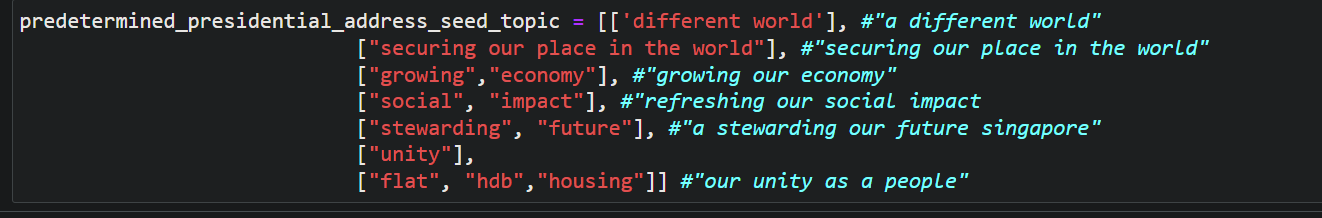

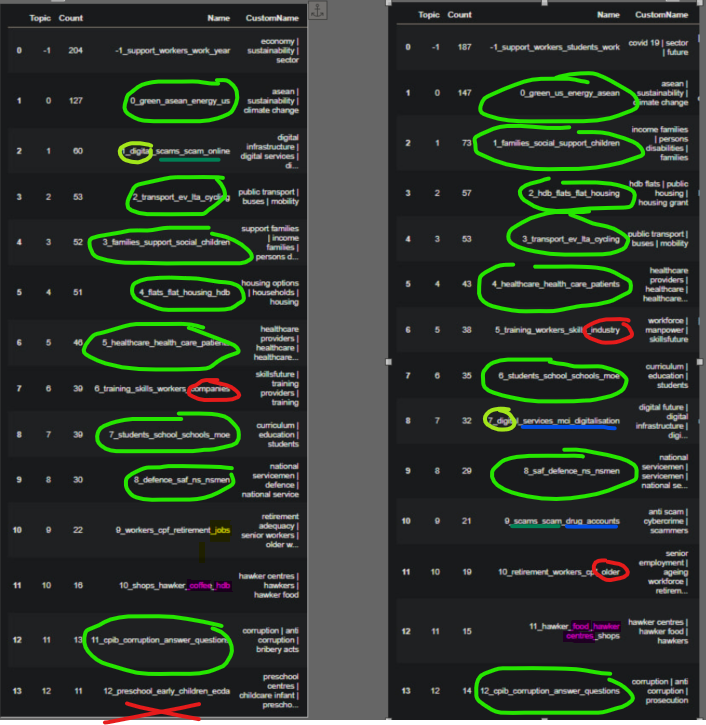

### Not sure some topics got absorbed and changed... but there is some changes

## Feature 2: Unsupervised fine-grained hierachical clustering for the users - NOTE- Thing changed slightly NEED to re-screenshot (DONE)
- Do hierachical clustering for other topics
- What other topics can be visualised(fine-grained)
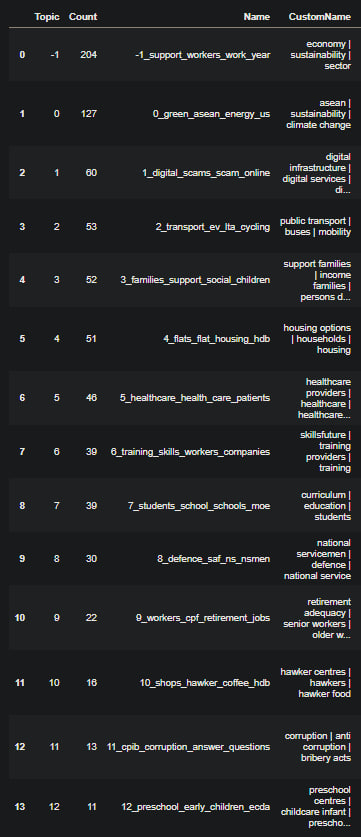

### Topic 0: Asean, Sustainability, Future
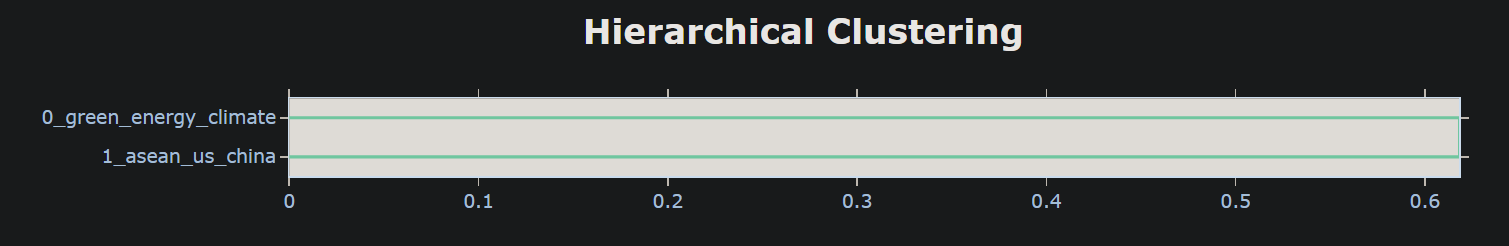

### Topic 1: Digital Infrastructure, Digital Services
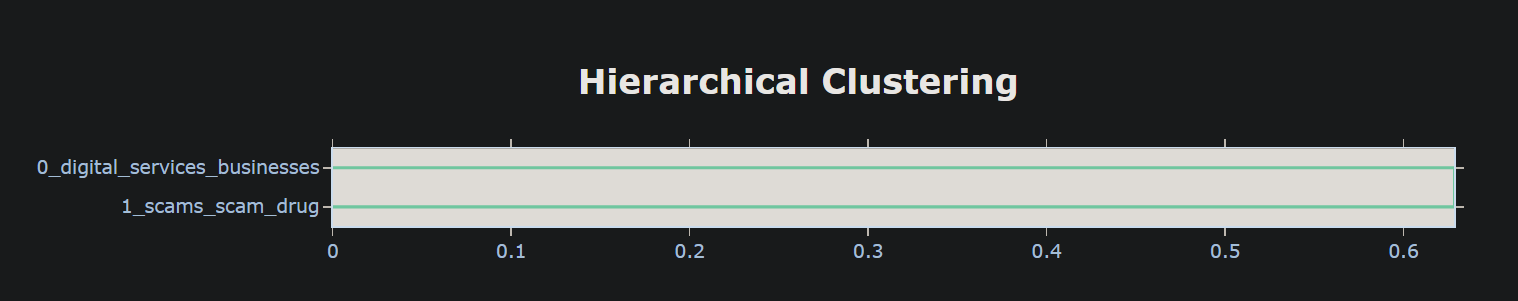

### Topic 2: Transport, Ev, LTA, Cycling
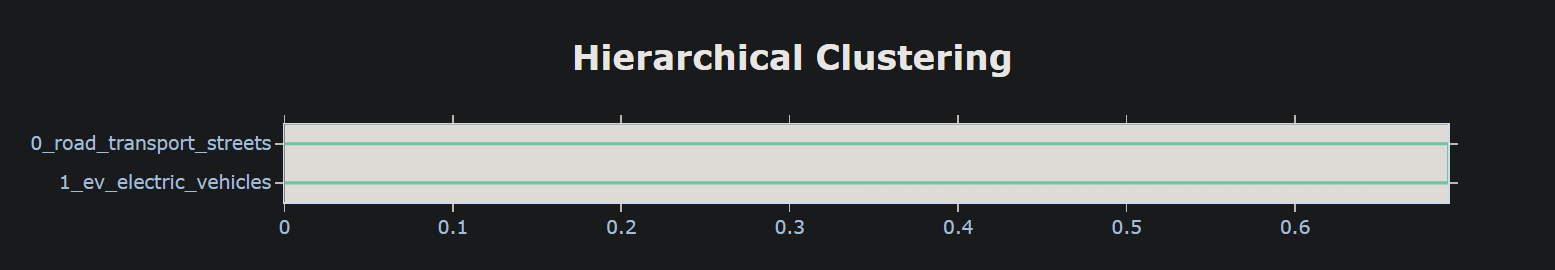

### Topic 3: Families, Support, Social, Children
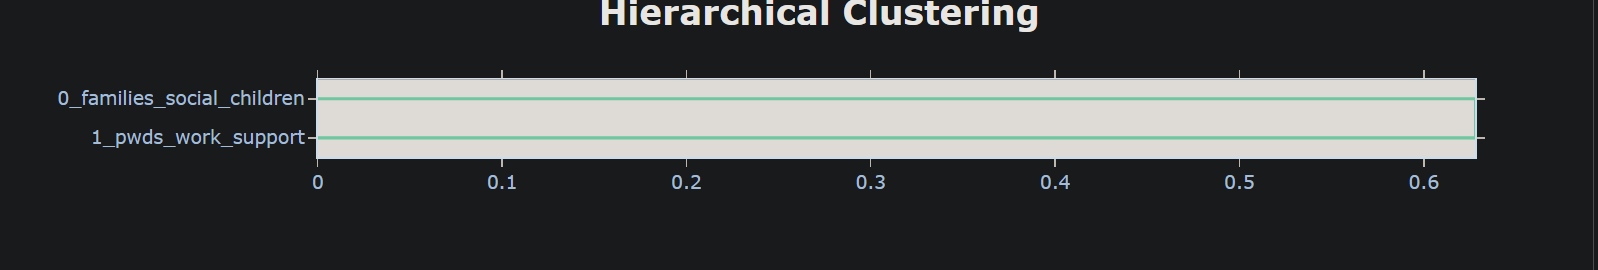

In [158]:
#Asean | sustainability | future', 'persons disabilities | disabilities 
#| income families', 'housing | public transport | residents', 'manpower | productivity | training providers
#Topic 0: ASEAN, Sustainability, Climate Change
#Topic 1: Digital Infrastructure, Digital Services
#Topic 2: Transport, Ev, LTA, Cycling
#Topic 3: Families, Support, Social, Children

In [123]:
enhanced_BERT_copy.get_topic_freq()

Topic  Count
1      -1    204
2       0    127
3       1     60
10      2     53
7       3     52
11      4     51
4       5     46
5       6     39
9       7     39
0       8     30
6       9     22
12     10     16
13     11     13
8      12     11

In [133]:
df = pd.DataFrame({"Document": combined_cos_speech, "Topic": enhanced_BERT_copy.topics_})
topic_number = input()
current_topic = df.query(f"Topic == {topic_number}")

3


In [134]:
fine_grained_enhanced_BERT = BERTopic(
    #umap_model=umap_model,
    #hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    top_n_words=15, #User judgement call; can put 20 or 25 - KIV: Dont optimize first
    language='english',
    calculate_probabilities=True,
    verbose=True
)

current_topic_speech = list(current_topic["Document"])
cos_topics, cos_probs = fine_grained_enhanced_BERT.fit_transform(current_topic_speech)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-30 08:11:53,584 - BERTopic - Transformed documents to Embeddings
2023-11-30 08:11:54,491 - BERTopic - Reduced dimensionality
2023-11-30 08:11:54,495 - BERTopic - Clustered reduced embeddings


In [135]:
fine_grained_hierarchical_topics = fine_grained_enhanced_BERT.hierarchical_topics(current_topic_speech)
fine_grained_enhanced_BERT.visualize_hierarchy(hierarchical_topics=fine_grained_hierarchical_topics)

100%|██████████| 1/1 [00:00<00:00, 230.06it/s]


### Possible limitations: Not enough data to "see" fine-granuality - Currrently only at Level 2
- Maybe need to scrap one more year of COS(If got time)                                                                          

## Feature 2.2: Supervised fine-grained hierachical clustering for the users
- User have already Housing, Education, Climate, Manpower, Digitalisation Topics to find
- Example: Each of them 3 “child” topics – Digitilisation (ML, Digital Tools, Digitial Payments)
- See how the child topics are linked to each other?

### Example from https://maartengr.github.io/BERTopic/getting_started/supervised/supervised.html with labelled dataset

In [139]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
docs = data['data']
y = data['target']

In [143]:
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression

# Get labeled data
data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
docs = data['data']
y = data['target']

# Skip over dimensionality reduction, replace cluster model with classifier,
# and reduce frequent words while we are at it.
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Create a fully supervised BERTopic instance

topic_model = BERTopic(
        umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model,
        verbose = True
)
topics, probs = topic_model.fit_transform(docs, y=y)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2023-11-30 08:40:41,572 - BERTopic - Transformed documents to Embeddings
2023-11-30 08:40:41,572 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-11-30 08:40:41,572 - BERTopic - Reduced dimensionality
2023-11-30 08:40:43,165 - BERTopic - Clustered reduced embeddings


In [144]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0       0    999                              0_game_hockey_team_25   
1       1    997                          1_god_church_jesus_christ   
2       2    996                              2_bike_dod_ride_bikes   
3       3    994                            3_baseball_game_he_year   
4       4    991                        4_key_encryption_db_clipper   
5       5    990                             5_car_cars_engine_ford   
6       6    990                  6_medical_patients_cancer_disease   
7       7    988                       7_window_server_widget_motif   
8       8    987                          8_space_launch_nasa_orbit   
9       9    985  9_maxaxaxaxaxaxaxaxaxaxaxaxaxaxax_windows_dos_...   
10     10    984                     10_circuit_wire_wiring_voltage   
11     11    982                       11_drive_scsi_ide_controller   
12     12    975                   12_sale_shipping_offer_condition   
13     13    973                      13_image_jpeg_graphics_images   
14     14    963                         14_mac_apple_drive_monitor   
15     15    940                  15_armenian_armenians_were_israel   
16     16    910                           16_gun_guns_firearms_fbi   
17     17    799                        17_god_atheists_atheism_not   
18     18    775               18_president_stephanopoulos_mr_myers   
19     19    628                        19_god_jesus_jehovah_elohim   

                                       Representation  \
0   [game, hockey, team, 25, season, 550, nhl, pla...   
1   [god, church, jesus, christ, we, not, he, his,...   
2   [bike, dod, ride, bikes, riding, motorcycle, m...   
3   [baseball, game, he, year, hit, players, games...   
4   [key, encryption, db, clipper, chip, keys, pri...   
5   [car, cars, engine, ford, oil, dealer, my, it,...   
6   [medical, patients, cancer, disease, health, v...   
7   [window, server, widget, motif, file, entry, x...   
8   [space, launch, nasa, orbit, shuttle, spacecra...   
9   [maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, windows, dos...   
10  [circuit, wire, wiring, voltage, ground, use, ...   
11  [drive, scsi, ide, controller, card, drives, b...   
12  [sale, shipping, offer, condition, 1st, price,...   
13  [image, jpeg, graphics, images, format, gif, 3...   
14  [mac, apple, drive, monitor, lc, quadra, mhz, ...   
15  [armenian, armenians, were, israel, turkish, j...   
16  [gun, guns, firearms, fbi, weapons, fire, they...   
17  [god, atheists, atheism, not, is, religion, th...   
18  [president, stephanopoulos, mr, myers, that, w...   
19  [god, jesus, jehovah, elohim, bible, that, he,...   

                                  Representative_Docs  
0   [NHL RESULTS FOR GAMES PLAYED 4/15/93.\n\n----...  
1   [From Bit.listserv.christia\n\nZane writes...\...  
2   [   I need some advice on having someone ride ...  
3   [I thought I'd post my predicted standings sin...  
4   [This document is in the anonymous ftp directo...  
5   [It's been a while since I've reviewed a car b...  
6   [------------- cut here -----------------\n\n\...  
7   [Archive-name: Intel-Unix-X-faq\nLast-modified...  
8   [Archive-name: space/acronyms\nEdition: 8\n\nA...  
9   [I don't know much about computers, so please ...  
10  [: \n: >What kind of power must he be putting ...  
11  [: \n: >Recently my cousin got a second intern...  
12  [These are comics I want to sell that are X-co...  
13  [Archive-name: graphics/resources-list/part1\n...  
14  [or\nthere\n\n\nOkay, I guess its time for a q...  
15  [Accounts of Anti-Armenian Human Right Violati...  
16  [[This is a co-authored report from two of us ...  
17  [Archive-name: atheism/logic\nAlt-atheism-arch...  
18  [SECRET PURPOSE OF FALKLANDS WAR;  [with IN-VI...  
19  [\n#Rick Anderson replied to my letter with......

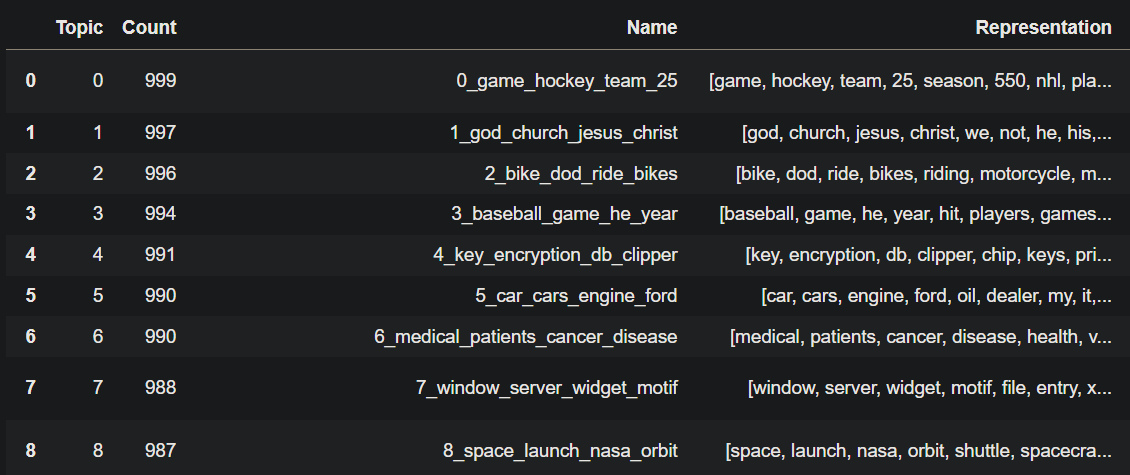

## For instance... like Healthcare(Topic 6)... we already pre-hand know cancer, disease, health... need to see the linking

In [145]:
df = pd.DataFrame({"Document": docs, "Topic": topic_model.topics_})
topic_number = input()
current_topic = df.query(f"Topic == {topic_number}")

6


In [148]:
fine_grained_enhanced_BERT = BERTopic(
    #umap_model=umap_model,
    #hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    min_topic_size = 10,
    nr_topics = 15,
    top_n_words=15, #User judgement call; can put 20 or 25 - KIV: Dont optimize first
    language='english',
    calculate_probabilities=True,
    verbose=True
)

current_topic_speech = list(current_topic["Document"])
cos_topics, cos_probs = fine_grained_enhanced_BERT.fit_transform(current_topic_speech)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2023-11-30 08:48:13,870 - BERTopic - Transformed documents to Embeddings
2023-11-30 08:48:16,067 - BERTopic - Reduced dimensionality
2023-11-30 08:48:16,116 - BERTopic - Clustered reduced embeddings
2023-11-30 08:48:31,588 - BERTopic - Reduced number of topics from 25 to 15


In [150]:
fine_grained_enhanced_BERT.get_topic_info()

Topic  Count                                               Name  \
0      -1    238                           -1_one_water_use_disease   
1       0    277                            0_edu_com_health_cancer   
2       1     88                      1_candida_yeast_infection_one   
3       2     80                          2_msg_food_chinese_people   
4       3     62                     3_science_one_scientific_think   
5       4     40  4_kirlian_photography_kirlian photography_pict...   
6       5     33             5_cancer_center_cancer center_research   
7       6     32                           6_good hello_hello_good_   
8       7     26                          7_hernia_pain_arm_surgery   
9       8     26                           8_pms_fat_weight_vitamin   
10      9     22             9_kidney_stones_kidney stones_chromium   
11     10     21                      10_eye_prk_dominance_left eye   
12     11     17                            11_ear_hearing_wax_ears   
13     12     16           12_crohn_inflammation_cleansing_patients   
14     13     12                                  13_92_12 92_12_10   

                                       Representation  \
0   [one, water, use, disease, vitamin, hiv, medic...   
1   [edu, com, health, cancer, one, medical, infor...   
2   [candida, yeast, infection, one, disease, infe...   
3   [msg, food, chinese, people, foods, one, taste...   
4   [science, one, scientific, think, methodology,...   
5   [kirlian, photography, kirlian photography, pi...   
6   [cancer, center, cancer center, research, medi...   
7   [good hello, hello, good, , , , , , , , , , , , ]   
8   [hernia, pain, arm, surgery, fat, back, diet, ...   
9   [pms, fat, weight, vitamin, magnesium, pmt, su...   
10  [kidney, stones, kidney stones, chromium, calc...   
11  [eye, prk, dominance, left eye, dominant, rk, ...   
12  [ear, hearing, wax, ears, tinnitus, resound, a...   
13  [crohn, inflammation, cleansing, patients, col...   
14  [92, 12 92, 12, 10, 17 12, 17, hiv, 10 12, 11,...   

                                              KeyBERT  \
0   [diseases, infection, hiv, disease, medicine, ...   
1   [medical newsletter, newsletter, hospital, new...   
2   [candidiasis, yeast infections, candida albica...   
3   [msg, chinese food, foods, glutamate, allergic...   
4   [scientific, science, studies, skepticism, res...   
5   [krillean photography, krillean pictures, kiri...   
6   [pregnancy, sperm, ovule, birth, circumcision,...   
7                                [, , , , , , , , , ]   
8   [hernia, hernias, reflux esophagitis, surgery,...   
9   [diet, low fat, weight gain, metabolism, nutri...   
10  [kidney stones, kidney stone, prevent kidney, ...   
11  [eye dominance, eye dominant, retinal, sighted...   
12  [ear problems, hearing aids, hearing loss, ear...   
13  [colon cleansing, crohn disease, colitis, croh...   
14  [needles, syringe, needle, hiv transmission, p...   

                                                  MMR  \
0   [water, use, disease, vitamin, hiv, patients, ...   
1   [edu, com, health, cancer, medical, informatio...   
2   [candida, yeast, infection, disease, infection...   
3   [msg, food, chinese, foods, taste, corn, eat, ...   
4   [scientific, think, methodology, theory, examp...   
5   [kirlian, photography, kirlian photography, pi...   
6   [cancer, cancer center, centers, university, c...   
7   [good hello, hello, good, , , , , , , , , , , , ]   
8   [hernia, arm, surgery, fat, back, diet, ring, ...   
9   [magnesium, pmt, supplementation, premenstrual...   
10  [stones, kidney stones, chromium, calcium, mag...   
11  [eye, prk, dominance, left eye, rk, cornea, vi...   
12  [ear, hearing, wax, ears, tinnitus, resound, h...   
13  [crohn, inflammation, cleansing, colonics, col...   
14  [92, 12 92, 10, 17 12, hiv, aids, 03, needles,...   

                                                  POS  \
0   [one, water, use, disease, vitamin, medical, p...   
1   [health, c

In [153]:
### Merging topic 14 and 7
topics_to_merge = [-1, 6, 13] #Example - merge topic 1 and 8
fine_grained_enhanced_BERT.merge_topics(current_topic_speech, topics_to_merge)

In [154]:
fine_grained_enhanced_BERT.get_topic_info()

Topic  Count                                               Name  \
0      -1    282                                    -1_92_hiv_12_10   
1       0    277                            0_edu_com_health_cancer   
2       1     88                      1_candida_yeast_infection_one   
3       2     80                          2_msg_food_chinese_people   
4       3     62                     3_science_one_scientific_think   
5       4     40  4_kirlian_photography_kirlian photography_pict...   
6       5     33             5_cancer_center_cancer center_research   
7       6     26                          6_hernia_pain_arm_surgery   
8       7     26                           7_pms_fat_weight_vitamin   
9       8     22             8_kidney_stones_kidney stones_chromium   
10      9     21                       9_eye_prk_dominance_dominant   
11     10     17                            10_ear_hearing_wax_ears   
12     11     16           11_crohn_inflammation_cleansing_patients   

                                       Representation  \
0   [92, hiv, 12, 10, one, 12 92, patients, use, w...   
1   [edu, com, health, cancer, one, medical, infor...   
2   [candida, yeast, infection, one, disease, get,...   
3   [msg, food, chinese, people, foods, one, taste...   
4   [science, one, scientific, think, methodology,...   
5   [kirlian, photography, kirlian photography, pi...   
6   [cancer, center, cancer center, research, medi...   
7   [hernia, pain, arm, surgery, fat, back, diet, ...   
8   [pms, fat, weight, vitamin, magnesium, pmt, su...   
9   [kidney, stones, kidney stones, chromium, calc...   
10  [eye, prk, dominance, dominant, left eye, rk, ...   
11  [ear, hearing, wax, ears, tinnitus, aids, reso...   
12  [crohn, inflammation, cleansing, patients, col...   

                                              KeyBERT  \
0   [hiv, patients, medical newsletter, infection,...   
1   [medical newsletter, newsletter, hospital, med...   
2   [candidiasis, yeast infections, candida albica...   
3   [msg, chinese food, foods, glutamate, allergic...   
4   [scientific, science, studies, skepticism, res...   
5   [krillean photography, krillean pictures, kirl...   
6   [pregnancy, sperm, ovule, birth, circumcision,...   
7   [hernia, hernias, reflux esophagitis, surgery,...   
8   [diet, low fat, weight gain, metabolism, nutri...   
9   [kidney stones, kidney stone, prevent kidney, ...   
10  [eye dominance, eye dominant, retinal, sighted...   
11  [ear problems, hearing loss, ear canal, ears, ...   
12  [colon cleansing, crohn disease, colitis, croh...   

                                                  MMR  \
0   [hiv, one, 12 92, patients, use, water, aids, ...   
1   [edu, com, health, cancer, medical, informatio...   
2   [candida, yeast, infection, disease, infection...   
3   [msg, food, chinese, foods, taste, corn, eat, ...   
4   [scientific, think, methodology, theory, examp...   
5   [kirlian, photography, kirlian photography, pi...   
6   [cancer, cancer center, centers, university, c...   
7   [hernia, pain, arm, surgery, fat, diet, doctor...   
8   [magnesium, pmt, supplementation, premenstrual...   
9   [stones, kidney stones, chromium, calcium, mag...   
10  [eye, prk, dominance, left eye, rk, cornea, vi...   
11  [ear, wax, ears, tinnitus, aids, resound, hear...   
12  [crohn, inflammation, cleansing, colonics, col...   

                                                  POS  \
0   [one, patients, use, water, medical, disease, ...   
1   [health, cancer, one, medical, information, ke...   
2   [candida, yeast, infection, one, disease, infe...   
3   [msg, food, chinese, people, foods, one, taste...   
4   [science, one, scientific, methodology, theory...   
5   [photography, pictures, leaf, object, fields, ...   
6   [cancer, center, research, medical, centers, c...   
7   [hernia, pain, arm, surgery, fat, back, diet, ...   
8   [fat, weight, vitamin, magnesium, supplementat...   
9   [kidney, stones, chromium, calcium, st

In [156]:
guided_hierarchical_topics = fine_grained_enhanced_BERT.hierarchical_topics(current_topic_speech)
fine_grained_enhanced_BERT.visualize_hierarchy(hierarchical_topics=guided_hierarchical_topics)

100%|██████████| 11/11 [00:00<00:00, 148.23it/s]


### Can visualise how the topics are related to each other for i.e "Healthcare" if we have some knowledge of how the sub-topics are link to each other

# STOP HERE
# IGNORE BELOW FOR NOW - I think no label...
### Screenshot below is an example (Manually-selected)
### Supposed they have the topic "pandemic", "education", "sustainability", "housing, "digital", "asean", "public transport"

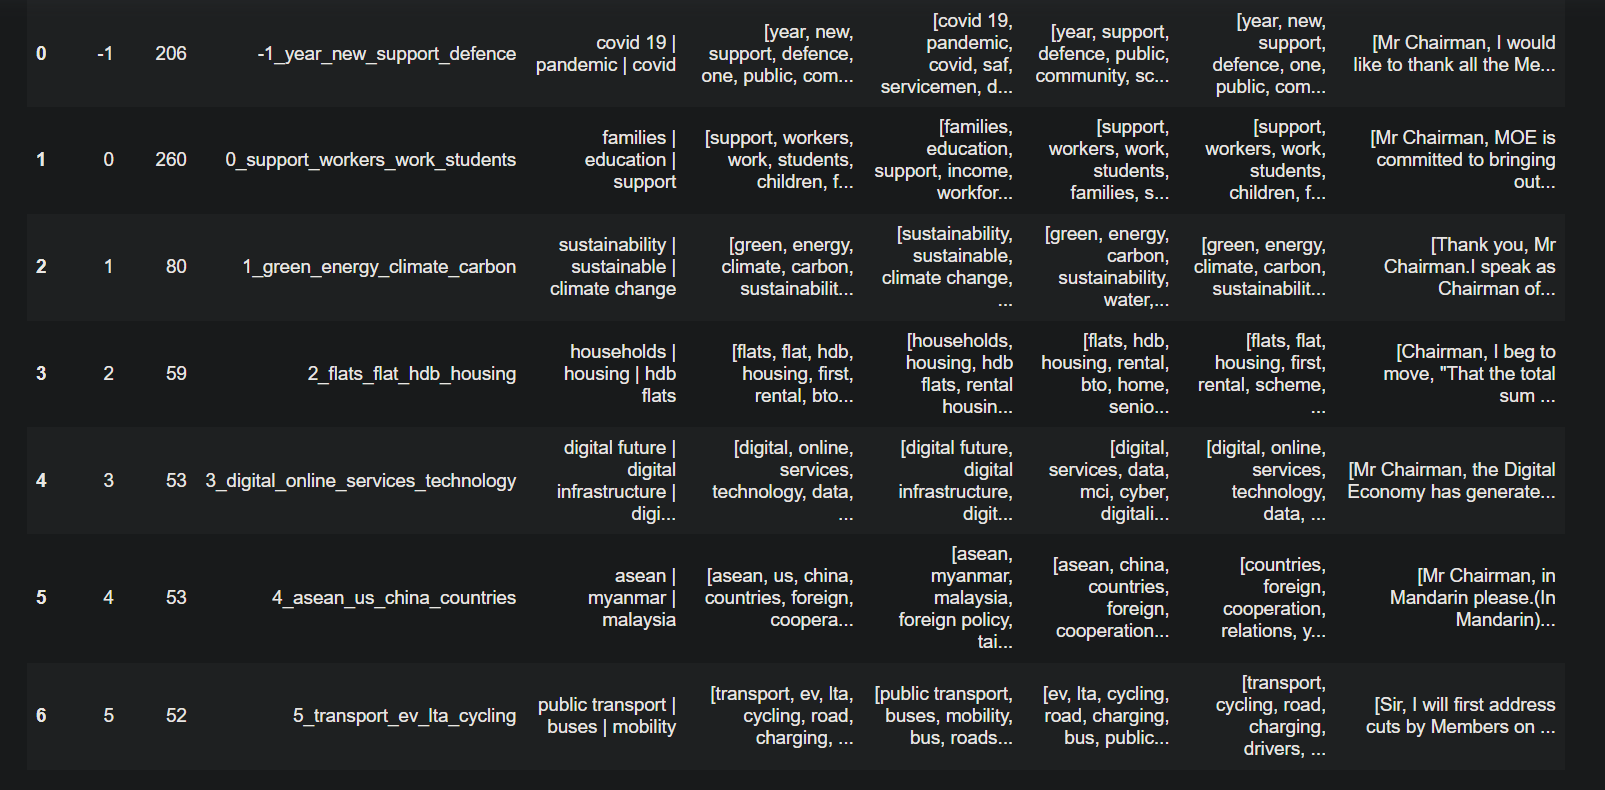

In [136]:
enhanced_BERT_copy.get_topic_info()

Topic  Count                                 Name  \
0      -1    204         -1_support_workers_work_year   
1       0    127              0_green_asean_energy_us   
2       1     60          1_digital_scams_scam_online   
3       2     53           2_transport_ev_lta_cycling   
4       3     52   3_families_support_social_children   
5       4     51             4_flats_flat_housing_hdb   
6       5     46    5_healthcare_health_care_patients   
7       6     39  6_training_skills_workers_companies   
8       7     39        7_students_school_schools_moe   
9       8     30               8_defence_saf_ns_nsmen   
10      9     22        9_workers_cpf_retirement_jobs   
11     10     16           10_shops_hawker_coffee_hdb   
12     11     13  11_cpib_corruption_answer_questions   
13     12     11     12_preschool_early_children_ecda   

                                           CustomName  \
0                   economy | sustainability | sector   
1             asean | sustainability | climate change   
2   digital infrastructure | digital services | di...   
3                 public transport | buses | mobility   
4   support families | income families | persons d...   
5              housing options | households | housing   
6   healthcare providers | healthcare | healthcare...   
7        skillsfuture | training providers | training   
8                   curriculum | education | students   
9    national servicemen | defence | national service   
10  retirement adequacy | senior workers | older w...   
11             hawker centres | hawkers | hawker food   
12        corruption | anti corruption | bribery acts   
13  preschool centres | childcare infant | prescho...   

                                       Representation  \
0   [support, workers, work, year, new, students, ...   
1   [green, asean, energy, us, climate, carbon, fo...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, ev, lta, cycling, road, charging, ...   
4   [families, support, social, children, pwds, wo...   
5   [flats, flat, housing, hdb, first, rental, bto...   
6   [healthcare, health, care, patients, moh, medi...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, moe, education, le...   
9   [defence, saf, ns, nsmen, mindef, national, se...   
10  [workers, cpf, retirement, jobs, work, employm...   
11  [shops, hawker, coffee, hdb, hawker centres, c...   
12  [cpib, corruption, answer, questions, kom, sai...   
13  [preschool, early, children, ecda, childcare, ...   

                                              KeyBERT  \
0   [economy, sustainability, sector, growth, covi...   
1   [asean, sustainability, climate change, plans,...   
2   [digital infrastructure, digital services, dig...   
3   [public transport, buses, mobility, bus, roads...   
4   [support families, income families, persons di...   
5   [housing options, households, housing, hdb fla...   
6   [healthcare providers, healthcare, healthcare ...   
7   [skillsfuture, training providers, training, s...   
8   [curriculum, education, students, educational,...   
9   [national servicemen, defence, national servic...   
10  [retirement adequacy, senior workers, older wo...   
11  [hawker centres, hawkers, hawker food, afforda...   
12  [corruption, anti corruption, bribery acts, pr...   
13  [preschool centres, childcare infant, preschoo...   

                                                  MMR  \
0   [support, workers, work, year, students, platf...   
1   [green, asean, energy, climate, carbon, sustai...   
2   [digital, scams, scam, online, services, data,...   
3   [ev, lta, cycling, road, charging, bus, public...   
4   [families, support, social, pwds, caregivers, ...   
5   [flats, housing, hdb, rental, bto, home, resal...   
6   [healthcare, health, patients, moh, healthier,...   
7   [training, skills, companies, training provide...   
8   [students, schools, moe, education, teachers, ...   
9   [defen

In [67]:
#I AM NOT SURE IF THIS IS CONSIDERED LABELLED cause there is no ground truth

#STOP at 12 am
#GUIDED Topic Modelling:

#EXAMPLE IF I HAVE THESE TOPICS ALREADY.... this is previously labelled
# seed_topic_list = ['platform workers' , 'workforce' ,'covid 19', 'asean', 'sustainability', 
#                    'future', 'persons disabilities', 'disabilities', 'income families', 
#                    'housing', 'flats', 'families', 
#                    'manpower' , 'productivity', 'training providers', 'scam victims',  'scammers' ,'cybercrime', 
#                    'hawker centres' , 'hawkers' , 'hawker food', 'senior employment', 'ageing workforce' ,'retirement adequacy',
#                    'corruption', 'anti corruption', 'bribery acts']
#cleaned_seed_topic = [s.replace('|', '') for s in seed_topic_list]

predetermined_seed_topic = [['pandemic','covid'],
                            ['families' ,'education','support'],
                            ['sustainability','sustainable','climate change'],
                            ['households','housing', 'hdb flats'],
                            ['digital future' 'digital infrastructure','digital services'],
                            [ 'asean','myanmar' ,'malaysia'],
                            ['public transport','buses','mobility']]

print(predetermined_seed_topic)

enhanced_BERT_guided = BERTopic(
    #umap_model=umap_model,
    #hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    #seed_topic_list=predetermined_seed_topic, 
    min_topic_size = 15,
    nr_topics = 15,
    top_n_words=15, #User judgement call; can put 20 or 25 - KIV: Dont optimize first
    language='english',
    calculate_probabilities=True,
    verbose=True
)

guided_topics, guided_probs = enhanced_BERT_guided.fit_transform(combined_cos_speech)

[['pandemic', 'covid'], ['families', 'education', 'support'], ['sustainability', 'sustainable', 'climate change'], ['households', 'housing', 'hdb flats'], ['digital futuredigital infrastructure', 'digital services'], ['asean', 'myanmar', 'malaysia'], ['public transport', 'buses', 'mobility']]


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-11-30 05:16:02,638 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-30 05:16:04,626 - BERTopic - Reduced dimensionality
2023-11-30 05:16:04,656 - BERTopic - Clustered reduced embeddings
2023-11-30 05:16:18,203 - BERTopic - Reduced number of topics from 19 to 10


In [69]:
enhanced_BERT_guided.get_topic_info()

Topic  Count                                         Name  \
0     -1    195                  -1_support_year_workers_new   
1      0    147                   0_green_food_public_energy   
2      1    121             1_support_families_children_care   
3      2     69                       2_asean_defence_us_saf   
4      3     60          3_workers_training_skills_companies   
5      4     52                4_digital_scams_scam_services   
6      5     37          5_students_school_schools_education   
7      6     36                     6_hdb_flats_flat_housing   
8      7     32  7_head_head main_head development_withdrawn   
9      8     14           8_cpib_corruption_answer_questions   

                                      Representation  \
0  [support, year, workers, new, work, students, ...   
1  [green, food, public, energy, sustainability, ...   
2  [support, families, children, care, social, wo...   
3  [asean, defence, us, saf, china, year, nationa...   
4  [workers, training, skills, companies, workfor...   
5  [digital, scams, scam, services, online, suppo...   
6  [students, school, schools, education, moe, le...   
7  [hdb, flats, flat, housing, first, scheme, bto...   
8  [head, head main, head development, withdrawn,...   
9  [cpib, corruption, answer, questions, kom, sai...   

                                             KeyBERT  \
0  [covid 19, manpower, pandemic, growth, sector,...   
1  [sustainability, sustainable, emissions, clima...   
2  [income families, families, caregivers, family...   
3  [asean, foreign policy, malaysia, national ser...   
4  [growth, economy, sector, sustainability, ente...   
5  [digital infrastructure, digital services, dig...   
6  [education system, curriculum, education, stud...   
7  [housing grant, hdb flats, rental flats, housi...   
8  [ministry, withdrawn, beg withdrawn, cut withd...   
9  [corruption, anti corruption, prosecution, cor...   

                                                 MMR  \
0  [support, workers, work, students, years, covi...   
1  [green, food, public, energy, sustainability, ...   
2  [support, families, children, care, social, he...   
3  [asean, defence, saf, year, myanmar, cooperati...   
4  [workers, training, skills, workforce, support...   
5  [digital, scams, scam, services, online, data,...   
6  [students, schools, education, secondary, teac...   
7  [hdb, flats, flat, housing, bto, rental, first...   
8  [head, head main, head development, withdrawn,...   
9  [cpib, corruption, questions, kom, individuals...   

                                                 POS  \
0  [support, year, workers, new, work, students, ...   
1  [green, food, public, energy, sustainability, ...   
2  [support, families, children, care, social, wo...   
3  [defence, year, national, foreign, cooperation...   
4  [workers, training, skills, companies, workfor...   
5  [digital, scams, scam, services, online, suppo...   
6  [students, school, schools, education, learnin...   
7  [flats, flat, housing, first, scheme, rental, ...   
8  [development, indulgence, cut, hon, cuts, enti...   
9  [corruption, answer, questions, individuals, i...   

                                 Representative_Docs  
0  [Mr Chairman, the Built Environment sector is ...  
1  [Mr Chairman, I thank Members for their cuts.B...  
2  [Chairman, I thank Members for their suggestio...  
3  [Mr Chairman, in Mandarin please.(In Mandarin)...  
4  [Mr Chairman, I thank the Members for their qu...  
5  [Mr Chairman, the Digital Economy has generate...  
6  [Sir, I commend MOE's introduction of  (SBB) i...  
7  [The  (PRS) assists Singaporeans with no alter...  
8  [Mr Chairman, if I may beg your indulgence, th...  
9  [Mr Chairman, five years ago, I spoke in this ...

In [65]:
guided_hierarchical_topics = enhanced_BERT_guided.hierarchical_topics(combined_cos_speech)
enhanced_BERT_guided.visualize_hierarchy(hierarchical_topics=guided_hierarchical_topics)

100%|██████████| 8/8 [00:00<00:00, 138.59it/s]


In [73]:
from scipy.cluster import hierarchy as sch

# Hierarchical topics
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = enhanced_BERT_guided.hierarchical_topics(combined_cos_speech, linkage_function=linkage_function)
enhanced_BERT_guided.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 8/8 [00:00<00:00, 126.61it/s]


In [74]:
tree = enhanced_BERT_guided.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──head_head main_head development_withdrawn_main ── Topic: 7
└─support_work_families_one_year
     ├─support_work_families_year_one
     │    ├─■──hdb_flats_flat_housing_first ── Topic: 6
     │    └─support_work_year_one_families
     │         ├─support_work_families_year_one
     │         │    ├─■──asean_defence_us_saf_china ── Topic: 2
     │         │    └─support_work_families_workers_one
     │         │         ├─support_families_workers_work_help
     │         │         │    ├─■──green_food_public_energy_sustainability ── Topic: 0
     │         │         │    └─support_families_workers_work_children
     │         │         │         ├─■──workers_training_skills_companies_workforce ── Topic: 3
     │         │         │         └─■──support_families_children_care_social ── Topic: 1
     │         │         └─■──digital_scams_scam_services_online ── Topic: 4
     │         └─■──students_school_schools_education_moe ── Topic: 5
     └─■──cpib_corruption_answer_questions_

### Evolution of BERTopic (How did Topic of healthcare change from 2019 to 2023?) - PENDING
- Potential problems -- no time?
- visualize_topics_over_time

In [30]:
#KIV:https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
#TODO: Put this as a function for varying topics
#TODO: Add fine-tuning using coherence score
cleaned_docs = enhanced_BERT._preprocess_text(combined_cos_speech)
vectorizer = enhanced_BERT.vectorizer_model
analyzer = vectorizer.build_analyzer()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topics = enhanced_BERT.get_topics()
topics.pop(-1, None)
final_topics = []
topic_words = [[word for word, _ in enhanced_BERT.get_topic(topic) if word != ""] for topic in topics]
topic_words = [[words for words, _ in enhanced_BERT.get_topic(topic)] for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                          texts=tokens, 
                          corpus=corpus,
                          dictionary=dictionary, 
                          coherence='u_mass') #c_v - Author do not recommend it: 0.7532062935248132 ;-1.296017161993158(u_mass)
coherence = coherence_model.get_coherence()

In [85]:
coherence

-1.296017161993158

#### Example Topic 1: Sustainability
##### BERTopic API variations:


Variations(Link not included check here - https://maartengr.github.io/BERTopic/index.html#attributes)
| Method                          | Code                                              |
|---------------------------------|---------------------------------------------------|
| Topic Distribution Approximation | `.approximate_distribution(docs)`                |
| Online Topic Modeling            | `.partial_fit(doc)`                               |
| Semi-supervised Topic Modeling   | `.fit(docs, y=y)`                                 |
| Supervised Topic Modeling        | `.fit(docs, y=y)`                                 |
| Manual Topic Modeling            | `.fit(docs, y=y)`                                 |
| Multimodal Topic Modeling        | `.fit(docs, images=images)`                       |
| Topic Modeling per Class         | `.topics_per_class(docs, classes)`                |
| Dynamic Topic Modeling           | `.topics_over_time(docs, timestamps)`             |
| Hierarchical Topic Modeling      | `.hierarchical_topics(docs)`                      |
| Guided Topic Modeling            | `BERTopic(seed_topic_list=seed_topic_list)`  

### 2.1.5.1 Qns f) Word summary for each topic for discussion (Pegasus)

In [159]:
#Recap
enhanced_BERT_copy.get_topic_info()

Topic  Count                                 Name  \
0      -1    204         -1_support_workers_work_year   
1       0    127              0_green_asean_energy_us   
2       1     60          1_digital_scams_scam_online   
3       2     53           2_transport_ev_lta_cycling   
4       3     52   3_families_support_social_children   
5       4     51             4_flats_flat_housing_hdb   
6       5     46    5_healthcare_health_care_patients   
7       6     39  6_training_skills_workers_companies   
8       7     39        7_students_school_schools_moe   
9       8     30               8_defence_saf_ns_nsmen   
10      9     22        9_workers_cpf_retirement_jobs   
11     10     16           10_shops_hawker_coffee_hdb   
12     11     13  11_cpib_corruption_answer_questions   
13     12     11     12_preschool_early_children_ecda   

                                           CustomName  \
0                   economy | sustainability | sector   
1             asean | sustainability | climate change   
2   digital infrastructure | digital services | di...   
3                 public transport | buses | mobility   
4   support families | income families | persons d...   
5              housing options | households | housing   
6   healthcare providers | healthcare | healthcare...   
7        skillsfuture | training providers | training   
8                   curriculum | education | students   
9    national servicemen | defence | national service   
10  retirement adequacy | senior workers | older w...   
11             hawker centres | hawkers | hawker food   
12        corruption | anti corruption | bribery acts   
13  preschool centres | childcare infant | prescho...   

                                       Representation  \
0   [support, workers, work, year, new, students, ...   
1   [green, asean, energy, us, climate, carbon, fo...   
2   [digital, scams, scam, online, services, data,...   
3   [transport, ev, lta, cycling, road, charging, ...   
4   [families, support, social, children, pwds, wo...   
5   [flats, flat, housing, hdb, first, rental, bto...   
6   [healthcare, health, care, patients, moh, medi...   
7   [training, skills, workers, companies, talent,...   
8   [students, school, schools, moe, education, le...   
9   [defence, saf, ns, nsmen, mindef, national, se...   
10  [workers, cpf, retirement, jobs, work, employm...   
11  [shops, hawker, coffee, hdb, hawker centres, c...   
12  [cpib, corruption, answer, questions, kom, sai...   
13  [preschool, early, children, ecda, childcare, ...   

                                              KeyBERT  \
0   [economy, sustainability, sector, growth, covi...   
1   [asean, sustainability, climate change, plans,...   
2   [digital infrastructure, digital services, dig...   
3   [public transport, buses, mobility, bus, roads...   
4   [support families, income families, persons di...   
5   [housing options, households, housing, hdb fla...   
6   [healthcare providers, healthcare, healthcare ...   
7   [skillsfuture, training providers, training, s...   
8   [curriculum, education, students, educational,...   
9   [national servicemen, defence, national servic...   
10  [retirement adequacy, senior workers, older wo...   
11  [hawker centres, hawkers, hawker food, afforda...   
12  [corruption, anti corruption, bribery acts, pr...   
13  [preschool centres, childcare infant, preschoo...   

                                                  MMR  \
0   [support, workers, work, year, students, platf...   
1   [green, asean, energy, climate, carbon, sustai...   
2   [digital, scams, scam, online, services, data,...   
3   [ev, lta, cycling, road, charging, bus, public...   
4   [families, support, social, pwds, caregivers, ...   
5   [flats, housing, hdb, rental, bto, home, resal...   
6   [healthcare, health, patients, moh, healthier,...   
7   [training, skills, companies, training provide...   
8   [students, schools, moe, education, teachers, ...   
9   [defen

In [163]:
#Finding the representations docs 
sample_rep_docs = enhanced_BERT_copy.get_representative_docs(1)
print(len(sample_rep_docs))

3


### NOTE: Memory error: DO NOT RUN MORE THAN ONCE

In [167]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

# Set device to GPU (CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'google/pegasus-large'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [168]:
ARTICLE = combined_sample_rep_docs
print(f"BEFORE SUMMARIZATION: {ARTICLE}")

BEFORE SUMMARIZATION: Mr Chairman, the Digital Economy has generated strong growth for Singapore, in particular, the Information and Communications, or I&C, sector has grown by 13.4% and 8.6% in 2021 and 2022 respectively. Going digital is no longer a "good to have" for our firms and workforce. To stay ahead of competition and meet the needs of their customers, our firms must go digital or risk being left behind. But we are doing so from a position of strength. Ninety-three percent of our firms have adopted at least one digital solution. Firms have improved their overall digital maturity over the years. However, given the uncertain economic outlook and near-term cost pressures, firms – especially our SMEs – may be tempted to press the "pause button" on their digitalisation plans. I urge these firms to reconsider.Firms may find it difficult to catch up later. In fact, I encourage firms to press "fast forward", to deepen digital capabilities and sharpen their competitiveness during this 

In [169]:
combined_sample_rep_docs = ' '.join(sample_rep_docs)
#text = "Your long text to summarize goes here..."

inputs = tokenizer.encode("summarize: " + combined_sample_rep_docs, return_tensors='pt', max_length=1024, truncation=True)
inputs = inputs.to(device)

# Generate the summary
summary_ids = model.generate(inputs, min_length=300, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

number_of_words = len(summary.split())
print(f"Number of words: {number_of_words}")
print(f"300 WORD SUMMARY: {summary}")

Number of words: 208
300 WORD SUMMARY: We are putting in place enablers at the national, sectoral and firm levels.This year, we will refresh the Retail IDP, the Security IDP and launch the Legal sector IDP.Mr Eric Chua and Mr Abdul Samad asked about helping the broader workforce keep up with technological changes. This year, we will refresh the Retail IDP, the Security IDP and launch the Legal sector IDP.Mr Eric Chua and Mr Abdul Samad asked about helping the broader workforce keep up with technological changes. This year, we will refresh the Retail IDP, the Security IDP and launch the Legal sector IDP.Mr Eric Chua and Mr Abdul Samad asked about helping the broader workforce keep up with technological changes. This year, we will refresh the Retail IDP, the Security IDP and launch the Legal sector IDP.Mr Eric Chua and Mr Abdul Samad asked about helping the broader workforce keep up with technological changes. This year, we will refresh the Retail IDP, the Security IDP and launch the Leg

### 2.1.5.2 word summary for each topic for discussion (BART) https://blog.paperspace.com/bart-model-for-text-summarization-part1/

In [61]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

ARTICLE = combined_sample_rep_docs
summarised_BART = summarizer(ARTICLE, min_length=142, truncation=True,do_sample=False)

In [62]:
number_of_words = len(summarised_BART[0]["summary_text"].split())
print(f"Number of words: {number_of_words}")
print(summarised_BART)

Number of words: 106
[{'summary_text': "I speak as Chairman of our Inter-Ministerial Committee on Climate Change (IMCCC) In Budget 2022, we announced Singapore's intention to raise our climate ambition. In October, after several months of public consultation, we formally revised our climate targets. We will reduce our emissions to around 60 million tonnes of CO2 equivalent in 2030, after peaking our emissions earlier. We also committed to achieving net-zero emissions by 2050. The Government, through IMCCC, strikes a balance between ambition and practicality of action. And it will take a whole-of-nation effort. The Green Plan sets out how the Government, businesses and the community can work together towards a greener future."}]


#### Note: Need to check up on how to control number of words for summary

### 2.1.5.3 Word Summarizer for BERT https://medium.com/@victor.dibia/implementing-extractive-text-summarization-with-bert-issue-4-e4856acb94ab

In [176]:
#pip install git+https://github.com/dmmiller612/bert-extractive-summarizer.git@small-updates
!pip uninstall charset-normalizer
!pip install charset-normalizer

^C


#### BERT https://theaidigest.in/summarize-text-document-using-transformers-and-bert/

In [178]:
from summarizer import Summarizer
#Create default summarizer model
model = Summarizer()
# Extract summary out of ''text"
# min_length = Minimum number of words.
# ratio = 1% of total sentences will be in summary.
model(ARTICLE, min_length=60, ratio=0.01)

RuntimeError: Failed to import transformers.sagemaker because of the following error (look up to see its traceback):
partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

### 2.1.5.1 Qns g) Identify which MPs frequently asked questions about each topic
- Assuming we identify the topic
1) Filter docs filter questions/clarifications
2) Find out which MP ask how many questions for each topic - Need to debug a bit - logic error

In [105]:
speech_with_questions = []
for ele in list(df.loc[df["topic"] == 1]["document"]):
    print(ele + "\n")
    if "?" in ele: #Temporary using this to idenify questions
        speech_with_questions.append(ele)

Thank you, Mdm Chair. Madam, I would like to declare my interest as an employee in the aviation sector.Our aviation and maritime hubs are amongst the leading global hubs. They also generate significant carbon emissions due to the reliance on fossil fuels to power the aircraft and ships. On the bright side, Changi Airport has been consistently rated not only as one of the world’s best airports but also one of the most environmentally-friendly. It is lauded for its skylights, abundance of greenery, energy-efficient motion sensors and lighting, water-efficient fittings and roof-mounted solar panels.Singapore remains in top position as the world's busiest container transshipment port, but we may not be amongst the most sustainable ones. According to a 2020 study of 36 seaports selected from North America, Europe (EU) and Asia Pacific, EU seaports had adopted more sustainability initiatives, compared to North American and Asia Pacific seaports.What is the strategy for both sectors to suppor

In [92]:
def merge_similar_keys(data): #Group the speeches by speakers
    merged_dict = defaultdict(list)
    for key, value in data.items():
        normalized_key = key.split(' (')[0]
        merged_dict[normalized_key].extend(value)
    return dict(merged_dict)

defaultdict(list)

defaultdict(list, {})

In [97]:
##Debugging this
## Space complexity might not go through ... use speech as key and value as speaker...

# Reverse lookup dictionary to reduce lookup time but need more memory
def reverse_lookup(my_dict):
    reverse_lookup_dict = defaultdict(list)
    for key, values in my_dict.items():
        for value in values:
            reverse_lookup_dict[value].append(key)
    return reverse_lookup_dict

In [129]:
#Forming a dictionary with speakers as keys and list of speeches he/she made
cos_all_speakerSpeechDict = defaultdict(list)

counting_keys = 0
for cos in cos_head_list:
    print(f"--------- Current COS: {cos}------------")
    cos_json = load_json_file(cos)
    for key, value in cos_json.items():
        counting_keys += 1
        normalized_key = key.split(' (')[0]
        cos_all_speakerSpeechDict[normalized_key].extend(value)
    print(counting_keys)
cos_all_speakerSpeechDict = dict(cos_all_speakerSpeechDict)

print(f"Total number of keys: {counting_keys}") #763? or 518 - A bit buggy here- Note: doest affect TM
print(f"Total number of speakers: {len(cos_all_speakerSpeechDict.keys())}")
print("\n")
speaker_counter = 0
for speaker, text_lst in cos_all_speakerSpeechDict.items():
    speaker_counter += 1
    print(speaker, len(text_lst))
    print("\n")
    for speech in text_lst:
        print(speech[:500]) #Cutting to the first 500 characters
        print("\n")
print(speaker_counter)

--------- Current COS: COS_HEAD_P_MHA------------
25
--------- Current COS: COS_HEAD_F_Parliment------------
28
--------- Current COS: COS_HEAD_O_MOH------------
68
--------- Current COS: COS_HEAD_I_MSF------------
96
--------- Current COS: COS_HEAD_W_MOT_I------------
125
--------- Current COS: COS_HEAD_W_MOT_II------------
140
--------- Current COS: COS_HEAD_I_MSF_II------------
148
--------- Current COS: COS_HEAD_T_MND------------
214
--------- Current COS: COS_HEAD_L_MSE_II------------
227
--------- Current COS: COS_HEAD_L_MSE_I------------
250
--------- Current COS: COS_HEAD_S_MOM------------
301
--------- Current COS: COS_HEAD_K_MOE_II------------
317
--------- Current COS: COS_HEAD_K_MOE_I------------
347
--------- Current COS: COS_HEAD_V_MTI------------
382
--------- Current COS: COS_HEAD_Q_MCI------------
408
--------- Current COS: COS_HEAD_N_MFA------------
442
--------- Current COS: COS_HEAD_J_MOD_I------------
453
--------- Current COS: COS_HEAD_J_MOD_II------------
480
---

In [107]:
#Run once only or it will flip back to a normal dict
cos_all_speakerSpeechDict = reverse_lookup(cos_all_speakerSpeechDict)

In [116]:
speakers_for_topicOne = {}
for question in speech_with_questions:
    speaker = cos_all_speakerSpeechDict[question][0]
    if speaker not in speakers_for_topicOne:
        speakers_for_topicOne[speaker] = 1
    else:
        speakers_for_topicOne[speaker] += 1

print("List of MPs asking questions for Topic1: Sustainability\n")
for key, value in speakers_for_topicOne.items():
    print(key,value)

List of MPs asking questions for Topic1: Sustainability

Ms Poh Li San 6
Miss Cheryl Chan Wei Ling 4
Mr Xie Yao Quan 1
Mr Liang Eng Hwa 1
Ms Carrie Tan 1
Ms Nadia Ahmad Samdin 4
Mr Chong Kee Hiong 1
Mr Leon Perera 1
Prof Koh Lian Pin 10
Mr Cheng Hsing Yao 1
Ms Tin Pei Ling 2
Mr Don Wee 4
Ms Indranee Rajah 1
Ms Grace Fu Hai Yien 1
Dr Amy Khor Lean Suan 1
Mr Louis Ng Kok Kwang 4
Mr Gan Thiam Poh 4
Dr Lim Wee Kiak 3
Ms Hany Soh 2
Mr Edward Chia Bing Hui 1
Mr Saktiandi Supaat 2
Mr Derrick Goh 1
Ms Jessica Tan Soon Neo 2
Ms Foo Mee Har 1
Ms Mariam Jaafar 2
Mr Abdul Samad 1
Mr Alvin Tan 1
Mr Pritam Singh 1


### Topic modelling by Speaker 

In [179]:
#Try COS MHA first
#print(list(COS_MHA_P.keys()))
COS_MHA_P_merged = merge_similar_keys(COS_MHA_P)
#print(len(COS_MHA_P_merged['Mr Pritam Singh']))
speaker_lst_text = COS_MHA_P_merged['Mr Pritam Singh']
for speech in speaker_lst_text:
    break
    print(speech[:500])
    print("\n")

print(f"Total Speaker: {len(COS_MHA_P_merged.keys())}")
print("\n")
for speaker, text_lst in COS_MHA_P_merged.items():
    print(speaker, len(text_lst))
    print("\n")
    for speech in text_lst:
        print(speech[:500])
        print("\n")

Total Speaker: 17


Mr Murali Pillai 2


Mr Chairman, Sir, I beg leave to move, "That the total sum to be allocated for Head P of the Estimates be reduced by $100".On 18 February 2023, the Operation Lionheart contingent of SCDF, comprising 68 officers, which included two Full-time National Servicemen doctors, and four canines returned home after being deployed in Türkiye for search and rescue operations. This followed the devastating earthquake that has to-date killed more than 50,000 people in the region.  Our officers under the comma


Mdm Chairperson, with your indulgence, I would like to thank the hon members who filed 27 cuts spanning 52.5 minutes on various topics that made this debate quite enriching. But I also would like to extend my appreciation to hon Second Minister and the two hon Ministers of State for their responses and outlining their strategies to keep Singapore safe and secure. And I am sure the hon Members who join me in wishing them well in their respective mission